### Master of Applied Artificial Intelligence

**Course: TC5035 - Proyecto Integrador**

<img src="../assets/logo.png" alt="Image Alt Text" width="500"/>

**Análisis exploratorio de datos**

Tutor: Dr. Horario Martinez Alfaro


Team members:
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394

In [ ]:
BetyMilo@@

# Imports

In [ ]:
!pip install category_encoders
!pip install shap
!pip install xgboost
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from tabulate import tabulate
from datetime import datetime
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import probplot

from category_encoders import OneHotEncoder
from category_encoders import TargetEncoder

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, confusion_matrix

from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import shap

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer


# Funciones

In [ ]:
class ExperimentalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, feature_name, transformation = None, parameters = None):
        #print(f'Transformation: {transformation}, over feature: {feature_name}')
        self.feature_name = feature_name
        self.transformation = transformation
        self.parameters = parameters

    def fit(self, X, y=None):
        print("Doing fit on feature ",self.feature_name)
        X_ = X.copy()
        # ------------------
        # TARGET ENCODER
        # ------------------
        if (self.transformation == 'apply_target_encoder'):
            if (np.size(y) <= 0):
                raise Exception('Target Encoder requires "y" value')
            t_enc = self.apply_target_encoder(X_, y, self.feature_name)
            self.target_encoder = t_enc
        elif (self.transformation == 'use_target_encoder'):
            self.target_encoder = self.parameters['encoder']
        # ------------------
        # ONE HOT ENCODER
        # ------------------
        elif (self.transformation == 'apply_one_hot_encoder'):
            oh_enc = self.apply_one_hot_encoder(X_, self.feature_name)
            self.one_hot_encoder = oh_enc
        # ------------------
        # TRANSFORMER
        # ------------------
        elif (self.transformation == 'apply_transformer'):
            self.transformer = self.parameters['transformer']
        # ------------------
        # IMPUTE NAN VALUES
        # ------------------
        elif (self.transformation == 'impute_nan'): # it's stateless
            specific_value = None
            if (self.parameters != None and self.parameters['specific_value'] != None):
                specific_value = self.parameters['specific_value']
            self.impute_nan(X_, self.feature_name, self.parameters['metric'], specific_value, 'train')
        # ------------------
        # DELETE INVALID VALUES
        # ------------------
        elif (self.transformation == 'set_nan_value'): # it's stateless
            # self.set_nan_value(X_, self.feature_name, self.parameters['min'], self.parameters['min'])
            pass
        # ------------------
        # TRUNCATE COLUMN
        # ------------------
        elif (self.transformation == 'column_truncate'): # it's stateless
            # column_truncate(df_train, df_test, col_name, 1, 1)
            pass
        elif (self.transformation == 'clean_features'): # it's stateless
            pass
        return self

    def transform(self, X, y=None):
        print("Doing transform on feature ",self.feature_name)
        X_ = X.copy()
        if (self.transformation == 'apply_target_encoder'):
            X_[self.feature_name] = self.target_encoder.transform(X_[self.feature_name])
        elif (self.transformation == 'use_target_encoder'):
            X_[self.feature_name] = self.target_encoder.transform(X_[self.feature_name])
        elif (self.transformation == 'apply_one_hot_encoder'):
            X_ = self.one_hot_encoder.transform(X_)
        elif (self.transformation == 'apply_transformer'):
            X_[self.feature_name] = self.transformer.transform(X_[self.feature_name])
        elif (self.transformation == 'set_nan_value'):
            X_[self.feature_name] = self.set_nan_value(X_, self.feature_name, self.parameters['min'], self.parameters['max'])
        elif (self.transformation == 'impute_nan'):
            specific_value = None
            if (self.parameters != None and self.parameters['specific_value'] != None):
                specific_value = self.parameters['specific_value']
            X_[self.feature_name] = self.impute_nan(X_, self.feature_name, self.parameters['metric'], specific_value)
        elif (self.transformation == 'column_truncate'):
            X_[self.feature_name] = self.column_truncate(X_, self.feature_name, self.parameters['upper_bound'], self.parameters['value'])
        elif (self.transformation == 'clean_features'):
            X_ = X_[self.parameters['features']]
        return X_

    def set_nan_value(self, df_train, col_name, lower_bound, upper_bound):
        '''
        Setea null a los valores de la columna fuera de los limites de lower_bound y upper_bound
        '''
        print("Doing transform on feature ",col_name, " | lower bound:", lower_bound, " | upper bound:", upper_bound)
        train_col = df_train[col_name].mask(((df_train[col_name] < lower_bound) | (df_train[col_name] >= upper_bound)), np.nan)
        return train_col

    def apply_target_encoder(self, df_train, y, col_name):
        '''
        Aplica un encoder de target contra churn y devuelve las columans para train
        y test
        '''
        t_enc = TargetEncoder()
        t_enc.fit(df_train[col_name],y)
        return t_enc

    def apply_one_hot_encoder(self, df_train, col_name):
        '''
        Aplica un one hot encoder y devuelve las columans para train
        y test
        '''
        clsfctn_enc = OneHotEncoder(use_cat_names=True,cols=[col_name])
        # se excluyen los nan para evitar que cree una columna para ellos
        clsfctn_enc.fit(df_train.dropna(subset=[col_name], inplace=False))
        return clsfctn_enc

    def impute_nan(self, df_train, col_name, metric='median',specific_value=None, state='test'):
        '''
        Imputa los valores nulos de la columna utilizando diferentes estrategias:
        * metric = 'median'
        * metric = 'mean'
        * metric = 'specific' con valor definido en specific_value
        '''
        if (state != 'test'):
            if metric=='median':
                self.impute_nan_value = df_train[col_name].median()
            elif metric == 'mean':
                self.impute_nan_value = df_train[col_name].mean()
            elif metric == 'specific':
                self.impute_nan_value = specific_value
            else:
                self.impute_nan_value = specific_value

        print("","The value on impute_nan is:", self.impute_nan_value)
        train_col = df_train[col_name].fillna(self.impute_nan_value, inplace=False)
        return train_col

    def column_truncate(self, df_train, col_name, upper_bound, value=None):
        '''
        Trunca el valor de una columna en cierto valor (upper_bound) y le coloca el valor (si es nulo utiliza el upper_bound)
        '''
        train_col = df_train[col_name].mask((df_train[col_name] >= upper_bound), value if value!=None else upper_bound)
        return train_col

In [ ]:
class Debug(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(X.shape)
        X.to_csv("x.csv", index=False)
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
def df_split(df):
    df_X = df.drop('sale',axis=1)
    df_y = df['sale']
    return df_X, df_y

In [ ]:
def under_sampling(X, y, ratio, random_state=123):
    under = RandomUnderSampler(random_state=random_state, sampling_strategy=ratio)
    return under.fit_resample(X, y)

In [ ]:
def threshold_truncate(y, scores, threshold):
  prediction = (scores >= threshold).astype(int)
  precision, recall, f1, o = precision_recall_fscore_support(y, prediction, average='binary', labels=[1,0])
  tn, fp, fn, tp = confusion_matrix(y, prediction).ravel()
  result = {
      'threshold': threshold
      #, 'prediction': prediction
      , 'positive_prediction': prediction.mean()
      , 'precision': precision
      , 'recall': recall
      , 'f1': f1
      , 'support': o
      , 'tn': tn
      , 'fp': fp
      , 'fn': fn
      , 'tp': tp
  }
  return result

In [ ]:
def threshold_iter(y, scores, min=0, max=1, step=0.1):
  if (min < 0):
    min = 0.0
  if (max > 1):
    max = 1.0
  if (not (min < step and step < max)):
    step = 0.1

  results = []
  for threshold in np.arange(min, max, step):
    result = threshold_truncate(y, scores, threshold)
    results.append(result)
  return results

In [ ]:
def plot_threshold_metrics(df):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
    fig.suptitle('Model metrics per threshold: ', fontsize=18)

    # Precision
    df.plot(x='threshold', y=['precision'], ax=axes[0])
    axes[0].set_title('Precision')

    # Precision
    df.plot(x='threshold', y=['recall'], ax=axes[1])
    axes[1].set_title('Recall')

    # Precision
    df.plot(x='threshold', y=['f1'], ax=axes[2])
    axes[2].set_title('F1')

    plt.tight_layout()

In [ ]:
def evaluate_shap_values(model, X_test, plot=False):
    # Fits the explainer
    explainer = shap.Explainer(model)
    # Calculates the SHAP values - It takes some time
    shap_values = explainer(X_test)
    if plot:
        shap.plots.bar(shap_values)
        shap.summary_plot(shap_values)
    return shap_values

In [ ]:
def plot_hist_prob(df, col_name, plot_transforms=True):
    if plot_transforms==False:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,3))

        # Histogram & Density
        sns.histplot(data=df, x=col_name, ax=axes[0], kde=True)
        axes[0].set_title('Histogram')

        # Probability Plot
        probplot(df[col_name], plot=axes[1])
        #axes[1].set_title(axes[1].get_title()+' Quantile Transformed data')

        # boxplot
        sns.boxplot(data=df, x=col_name, ax=axes[2], showfliers = True)
        axes[2].set_title('Boxplot')

        plt.tight_layout()
    else:
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,9))
        fig.suptitle(col_name, fontsize=18)

        # Histogram & Density
        sns.histplot(data=df, x=col_name, ax=axes[0,0], kde=True)
        axes[0,0].set_title('Histogram')

        # Probability Plot
        probplot(df[col_name], plot=axes[0,1])

        # boxplot
        sns.boxplot(data=df, x=col_name, ax=axes[0,2], showfliers = True)
        axes[0,2].set_title('Boxplot')

        df_tmp = df.copy()
        # -------------------------------
        # QUANTILE
        # -------------------------------
        q_transformer = QuantileTransformer(output_distribution='normal')
        q_transformer.fit(df_tmp[[col_name]])

        df_tmp['q_'+col_name] = q_transformer.transform(df_tmp[[col_name]])

        # Histogram & Density
        sns.histplot(data=df_tmp, x='q_'+col_name, ax=axes[1,0], kde=True)
        axes[1,0].set_title('Histogram')

        # Probability Plot
        probplot(df_tmp['q_'+col_name], plot=axes[1,1])

        # boxplot
        sns.boxplot(data=df_tmp, x='q_'+col_name, ax=axes[1,2], showfliers = True)
        axes[1,2].set_title('Boxplot')

        # -------------------------------
        # YEO JONSHON
        # -------------------------------
        yj_transformer = PowerTransformer(method='yeo-johnson')
        yj_transformer.fit(df_tmp[[col_name]])

        df_tmp['yj_'+col_name] = yj_transformer.transform(df_tmp[[col_name]])

        # Histogram & Density
        sns.histplot(data=df_tmp, x='yj_'+col_name, ax=axes[2,0], kde=True)
        axes[2,0].set_title('Histogram')

        # Probability Plot
        probplot(df_tmp['yj_'+col_name], plot=axes[2,1])

        # boxplot
        sns.boxplot(data=df_tmp, x='yj_'+col_name, ax=axes[2,2], showfliers = True)
        axes[2,2].set_title('Boxplot')


        plt.tight_layout()


# Data Preparation

## Import dataset

In [ ]:
import gdown
!mkdir data
url = 'https://drive.google.com/uc?export=download&id=1rmHf8nMsml059APC6ftFytKjVlUnbOUp'
output = 'data/sale.csv'
gdown.download(url, output, quiet=False)
df = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?export=download&id=1rmHf8nMsml059APC6ftFytKjVlUnbOUp
To: /content/data/sale.csv
100%|██████████| 299M/299M [00:02<00:00, 119MB/s]


In [ ]:
df.head()

state_name previous_classification  previous_calls  \
0         JALAPA              NEW CLIENT               0   
1      GUATEMALA              NEW CLIENT               0   
2   ALTA VERAPAZ          NOT INTERESTED               2   
3  CHIMALTENANGO          NOT INTERESTED               3   
4  HUEHUETENANGO          NOT INTERESTED               6   

   previous_not_effective_count  previous_not_interested_count client_gender  \
0                             0                              0             M   
1                             0                              0             F   
2                             1                              1             M   
3                             1                              2             M   
4                             4                              2             F   

   client_age  client_has_nit  network_age_years  rgus_prepaid  ...  \
0        69.0               1               3.16             3  ...   
1        28.0               1               3.90             2  ...   
2        44.0               1              12.88             4  ...   
3        56.0               1               1.94             6  ...   
4        45.0               1              13.37             2  ...   

   tiktok_gb  instagram_days  instagram_gb  whatsapp_days  whatsapp_gb  \
0     30.321               0         0.000             84        0.693   
1     42.442              89         0.425             89       20.237   
2      7.749               0         0.000             89       21.538   
3      2.739              82         0.125             82        2.072   
4      7.694              64         0.037             87        1.040   

   youtube_days  youtube_gb  music_days  music_gb  sale  
0            85       2.745           0     0.000    NO  
1            89       3.614          89     5.946    NO  
2            85       1.607          42     0.298    NO  
3            82       2.454           0     0.000    NO  
4            76       1.065          23     0.142    NO  

[5 rows x 60 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610083 entries, 0 to 610082
Data columns (total 60 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   state_name                           610068 non-null  object 
 1   previous_classification              610083 non-null  object 
 2   previous_calls                       610083 non-null  int64  
 3   previous_not_effective_count         610083 non-null  int64  
 4   previous_not_interested_count        610083 non-null  int64  
 5   client_gender                        458428 non-null  object 
 6   client_age                           458559 non-null  float64
 7   client_has_nit                       610083 non-null  int64  
 8   network_age_years                    610081 non-null  float64
 9   rgus_prepaid                         610083 non-null  int64  
 10  rgus_postpaid                        610083 non-null  int64  
 11  rgus_home    

In [ ]:
df['sale'] = (df['sale']=='SI').astype('int32')

## Select Features

In [ ]:
selected_columns = [
    'state_name'
    , 'previous_classification'
    , 'previous_calls'
    , 'client_age'
    , 'network_age_years'
    , 'banking'
    , 'arpu_90_days'
    , 'minutes_in'
    , 'validity_average'
    , 'average_performance'
    , 'start_using_months'
    , 'contacts'
    , 'high_frequency_contacts'
    , 'plan_postpaid'
    , 'sn_banking'
    , 'digital_index_mean'
    , 'connected_days'
    , 'charged_days'
    , 'apps_days'
    , 'music_gb'
    , 'sale'
]

In [ ]:
len(selected_columns)

21

In [ ]:
df_selected = df[selected_columns]

In [ ]:
df_selected.shape

(610083, 21)

## Train/Test Split

In [ ]:
df_train=df_selected.sample(frac=0.7,random_state=100)
df_test=df_selected.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_train.shape

(427058, 21)

In [ ]:
df_test.shape

(183025, 21)

In [ ]:
df_train.describe()

previous_calls     client_age  network_age_years        banking  \
count   427058.000000  320879.000000      427057.000000  427058.000000   
mean         1.406413      41.240527           3.753322       0.706590   
std          1.656201      12.445169           3.816367       0.455325   
min          0.000000       7.000000           0.010000       0.000000   
25%          0.000000      32.000000           1.090000       0.000000   
50%          1.000000      40.000000           2.530000       1.000000   
75%          2.000000      49.000000           4.950000       1.000000   
max         27.000000    2022.000000          25.370000       1.000000   

        arpu_90_days     minutes_in  validity_average  average_performance  \
count  427058.000000  427058.000000     427058.000000        427058.000000   
mean      129.689491      69.549010          7.122910             0.699338   
std        34.498689     110.727144          6.675478             0.179308   
min         0.000000       0.000000          0.000000             0.000000   
25%       105.010000      13.390000          2.680000             0.580000   
50%       120.220000      35.990000          5.240000             0.720000   
75%       145.380000      82.910000          8.110000             0.840000   
max       740.730000    9047.500000         30.000000             1.500000   

       start_using_months       contacts  high_frequency_contacts  \
count       427040.000000  427058.000000            427058.000000   
mean            10.769570      50.255820                 0.521763   
std             11.361819      38.084258                 0.133990   
min             -1.000000       0.000000                 0.000000   
25%              2.000000      25.000000                 0.440000   
50%              7.000000      41.000000                 0.520000   
75%             16.000000      65.000000                 0.610000   
max             93.000000     450.000000                 1.000000   

       plan_postpaid     sn_banking  digital_index_mean  connected_days  \
count  427058.000000  427058.000000       427058.000000   427058.000000   
mean        0.186584       0.365271            0.138517       85.851058   
std         0.190468       0.214550            0.287477       10.309549   
min         0.000000       0.000000            0.000000        0.000000   
25%         0.050000       0.220000            0.000000       86.000000   
50%         0.140000       0.330000            0.000000       91.000000   
75%         0.260000       0.480000            0.060000       91.000000   
max         1.000000       1.000000            1.000000       91.000000   

        charged_days      apps_days       music_gb           sale  
count  427058.000000  427058.000000  427058.000000  427058.000000  
mean       77.824621       3.388500       0.194037       0.037367  
std        16.046937       5.732648       0.897738       0.189660  
min         0.000000       0.000000       0.000000       0.000000  
25%        71.000000       0.000000       0.000000       0.000000  
50%        84.000000       1.000000       0.000000       0.000000  
75%        90.000000       4.000000       0.000000       0.000000  
max        91.000000      75.000000      65.499000       1.000000

## Evaluar Transformaciones

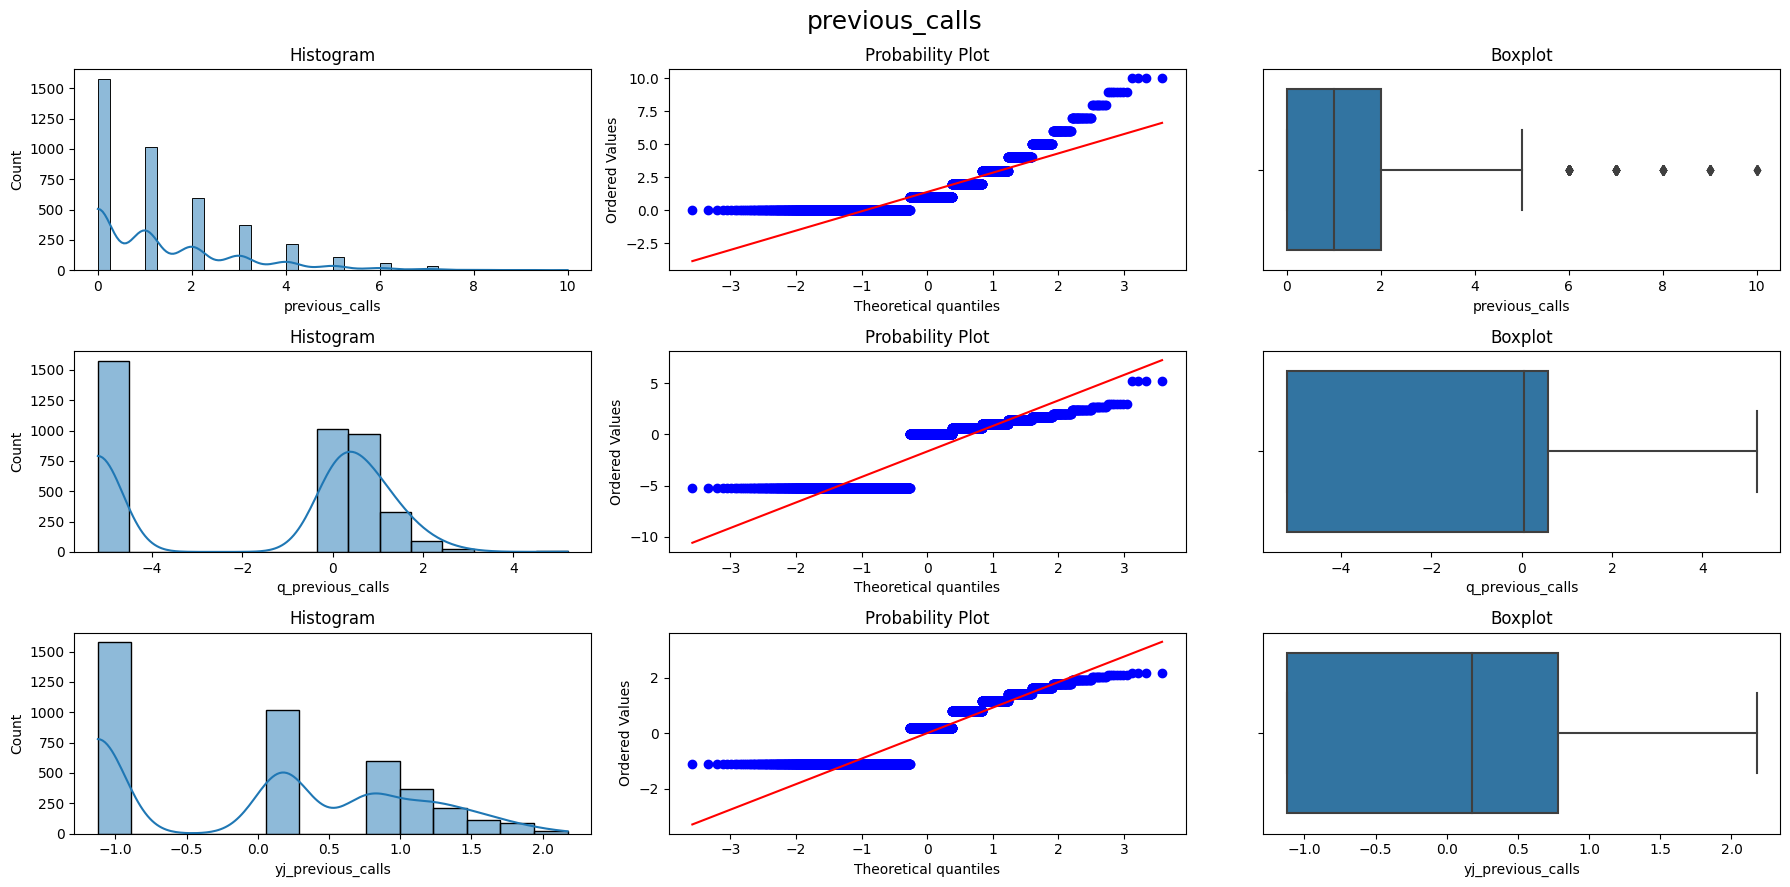

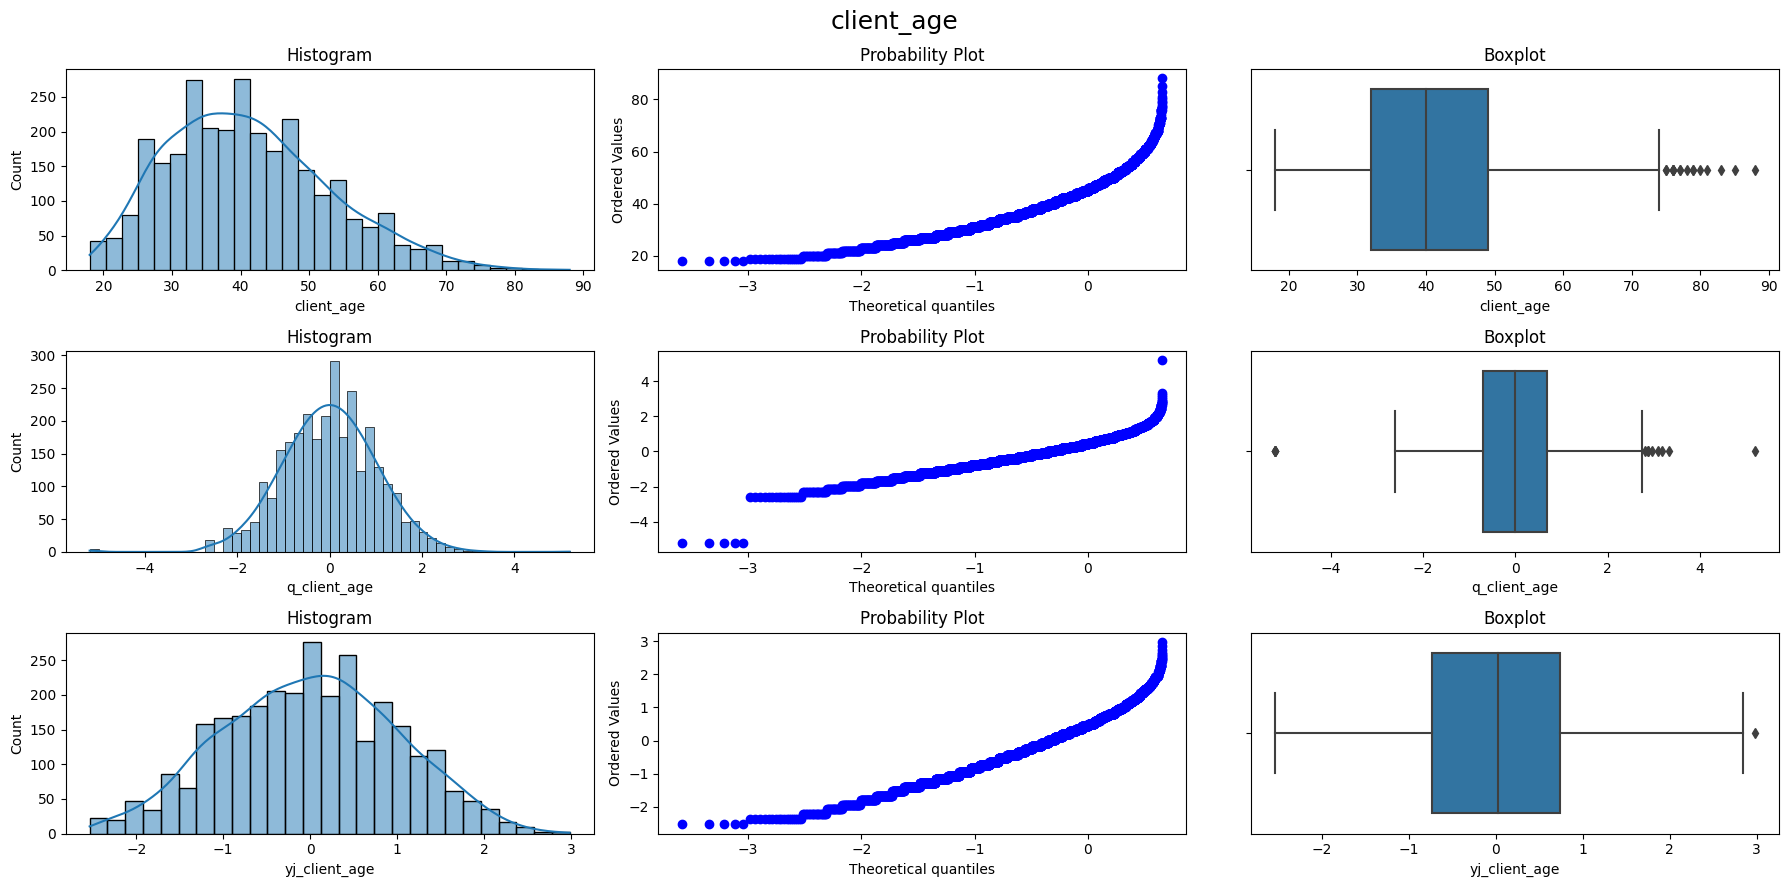

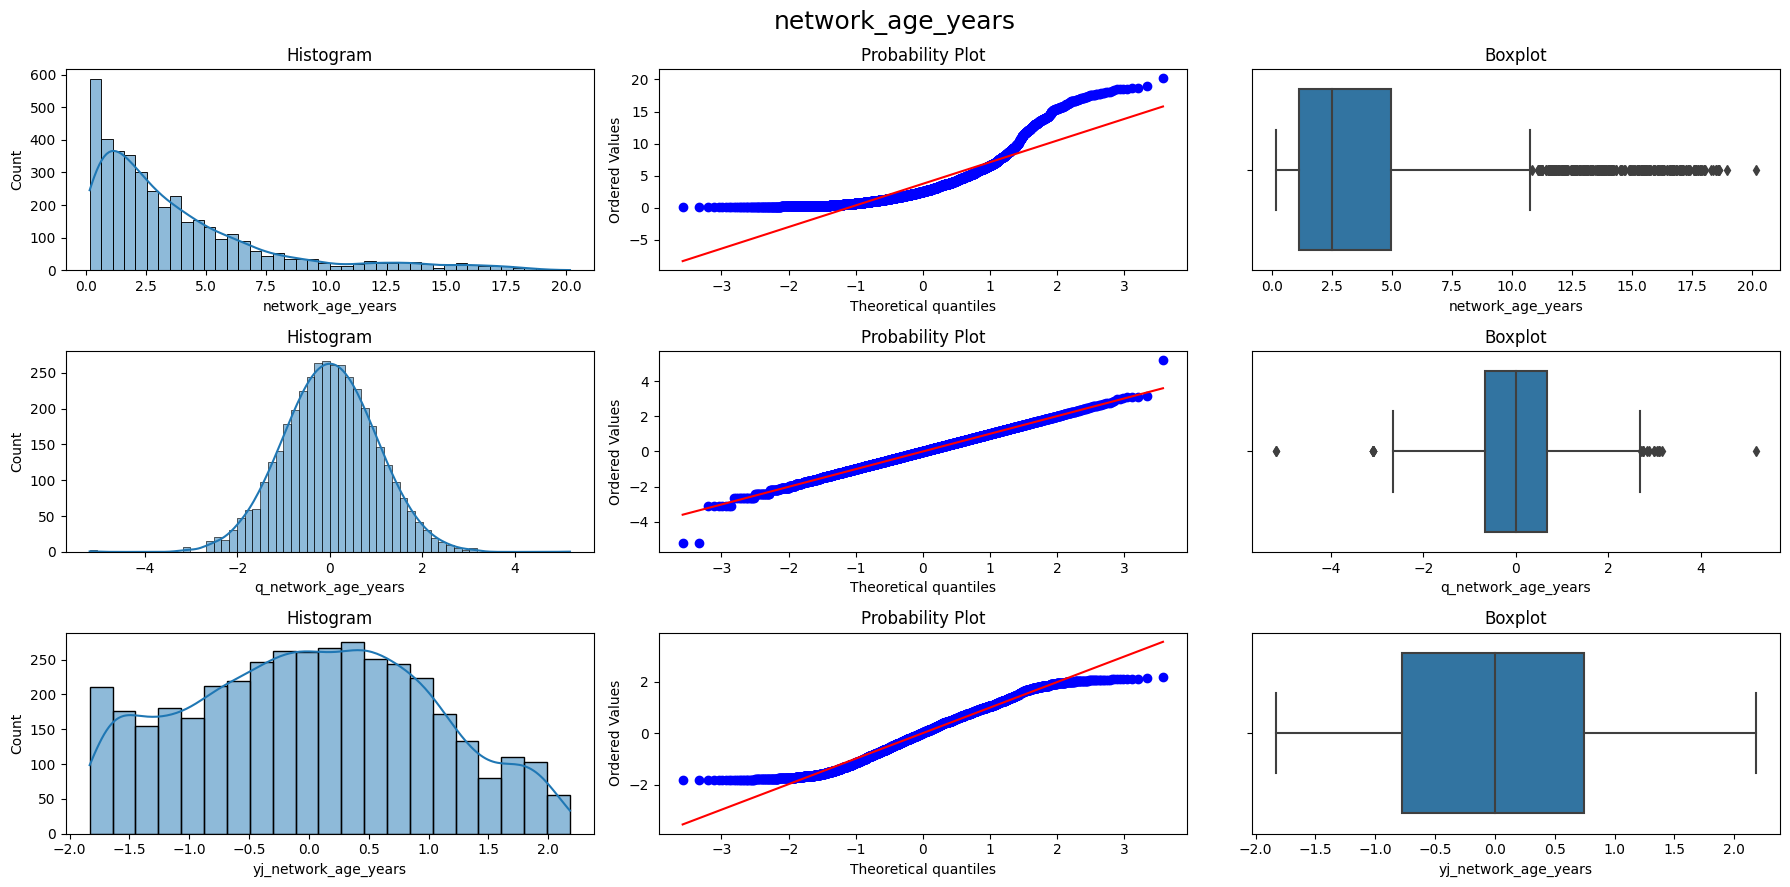

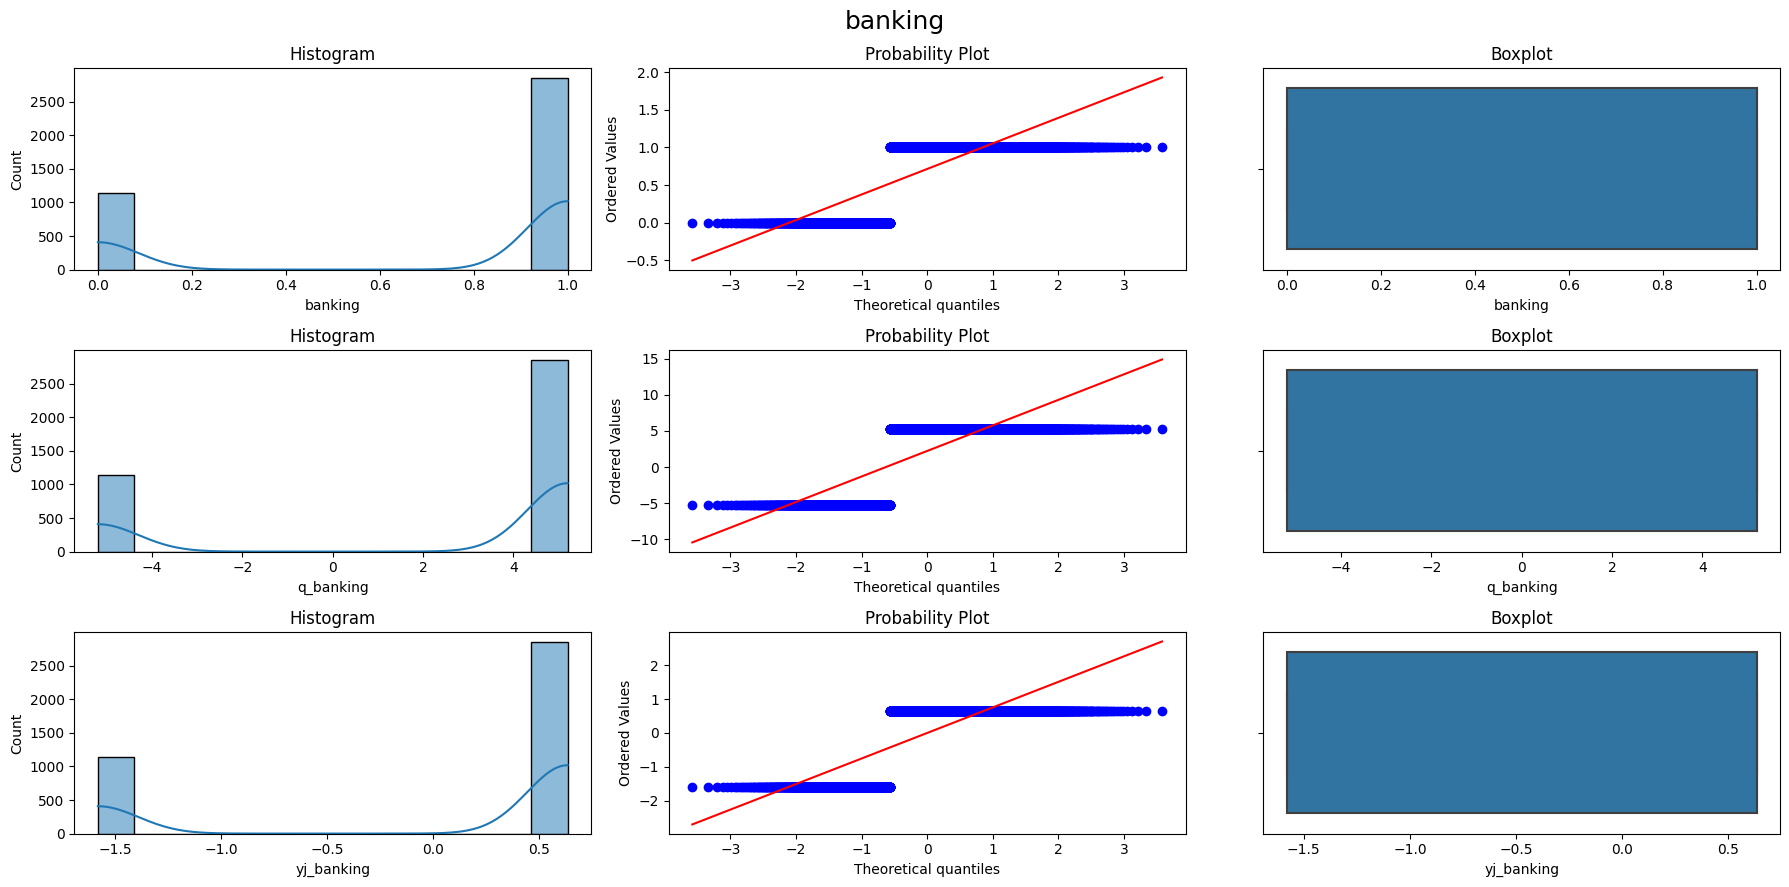

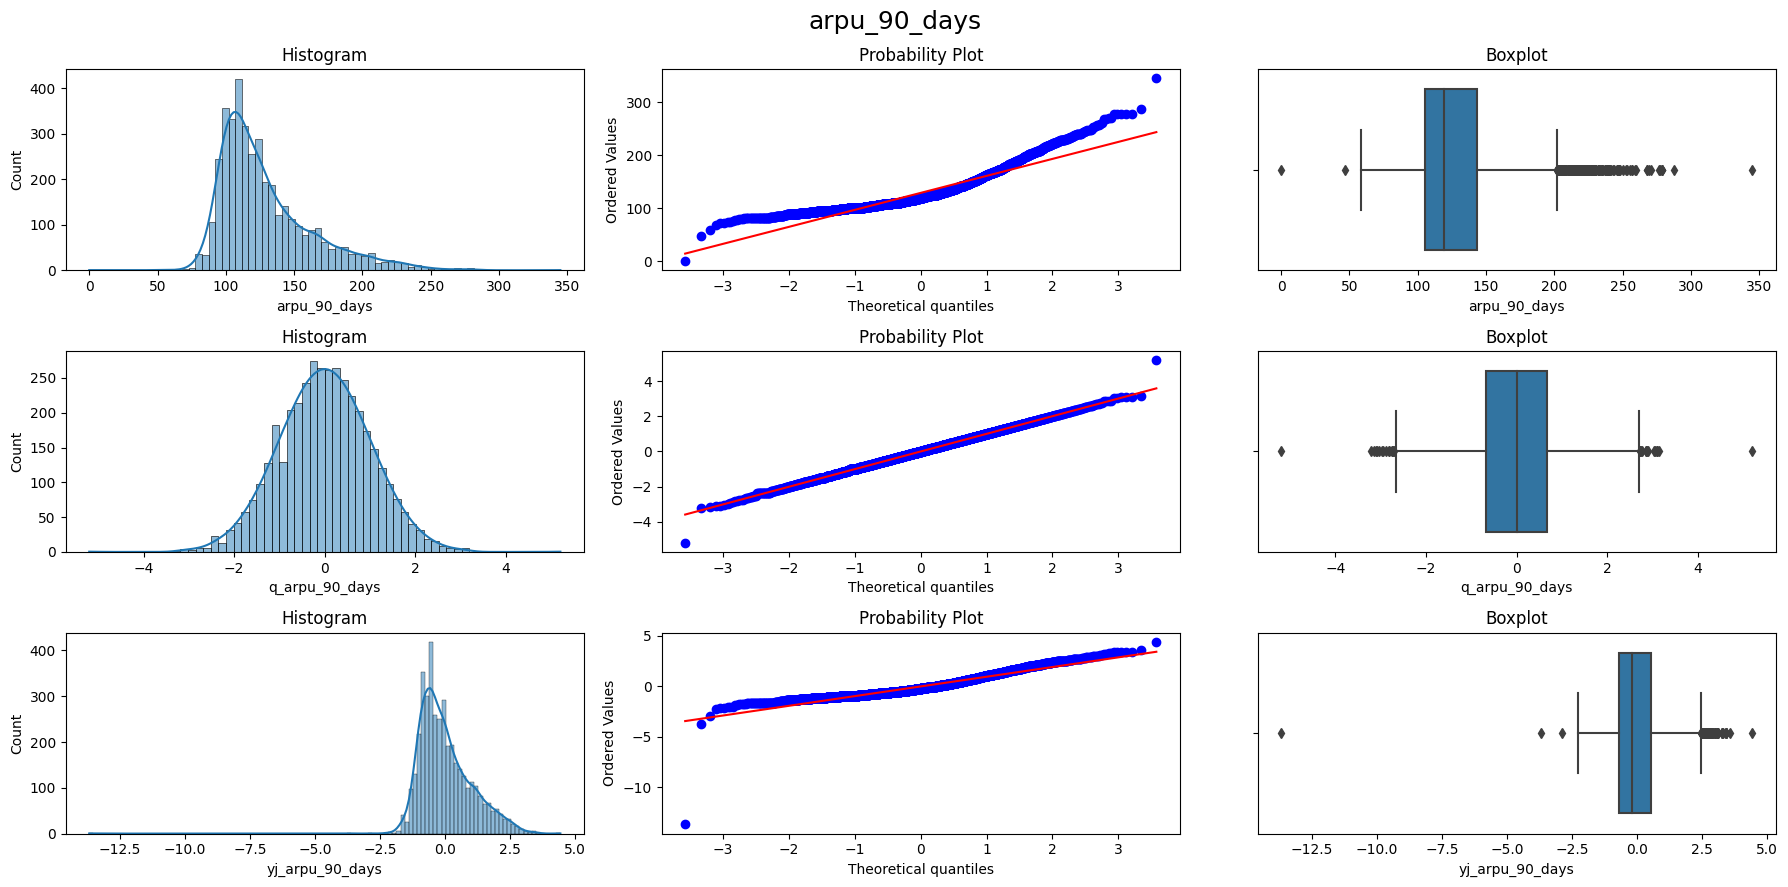

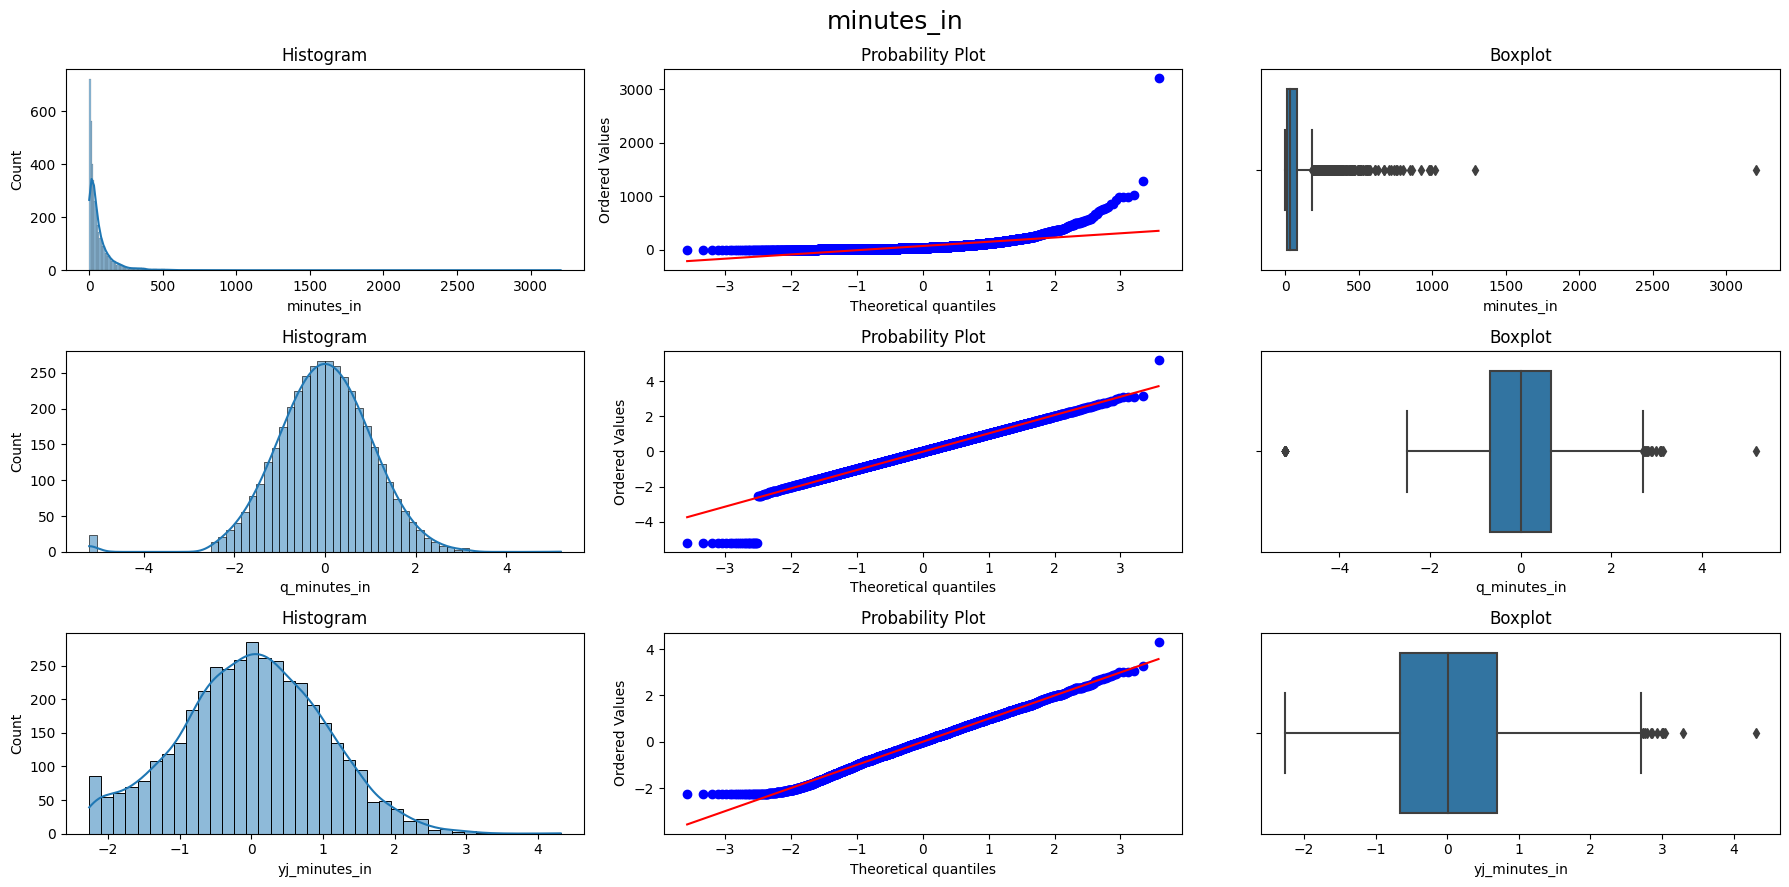

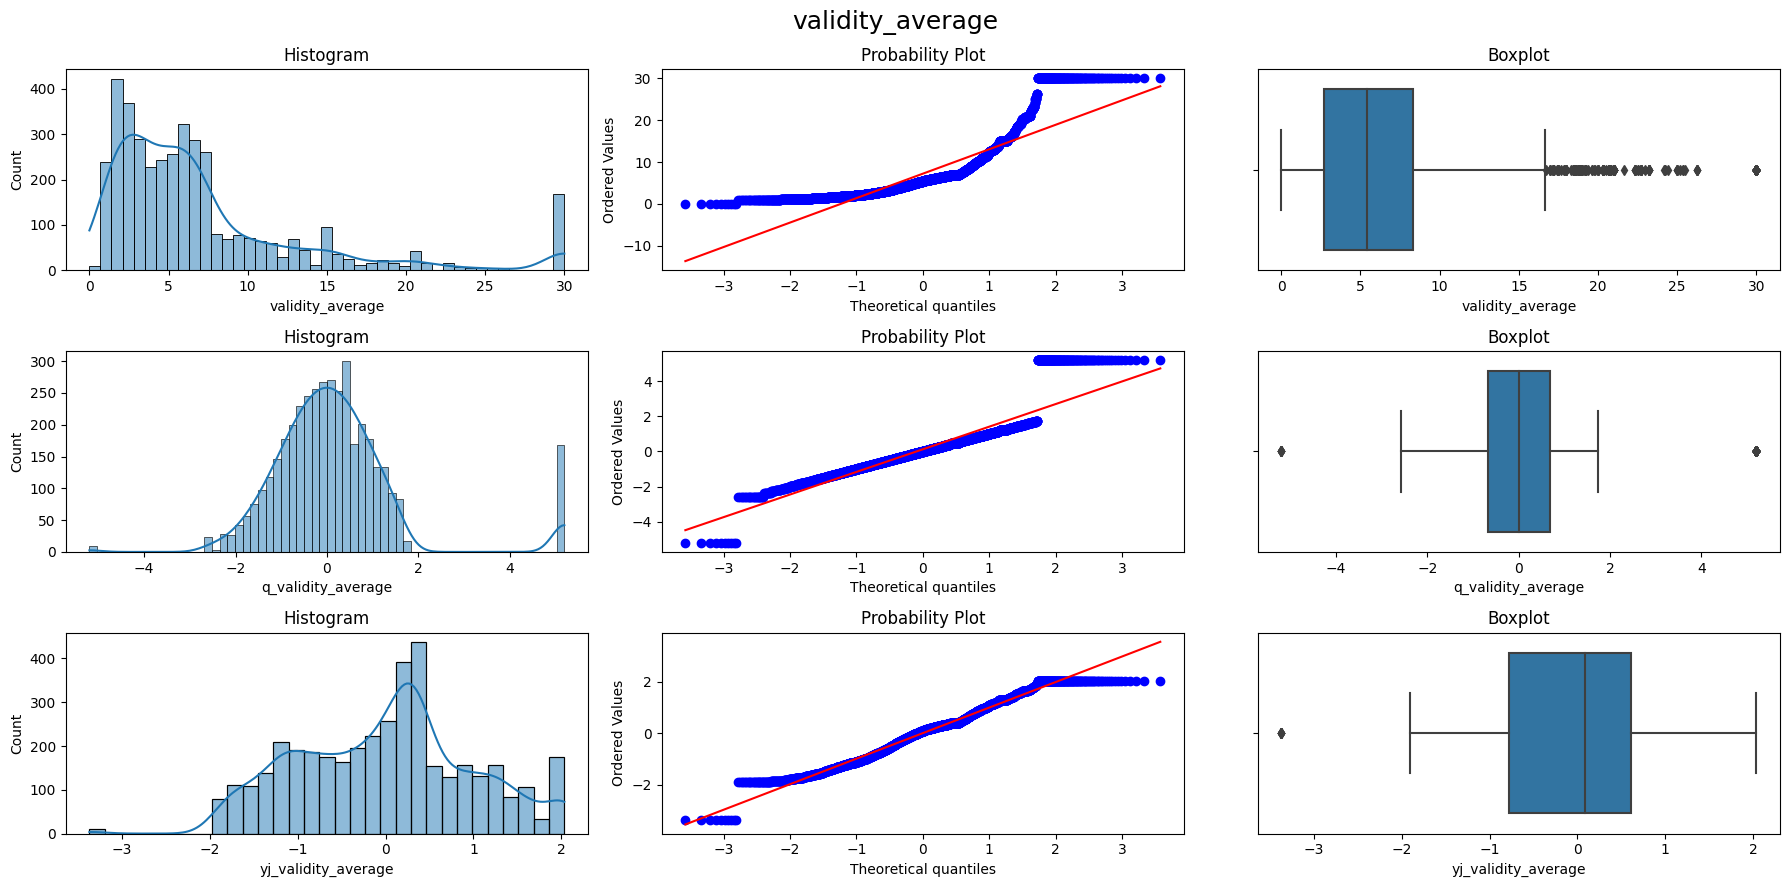

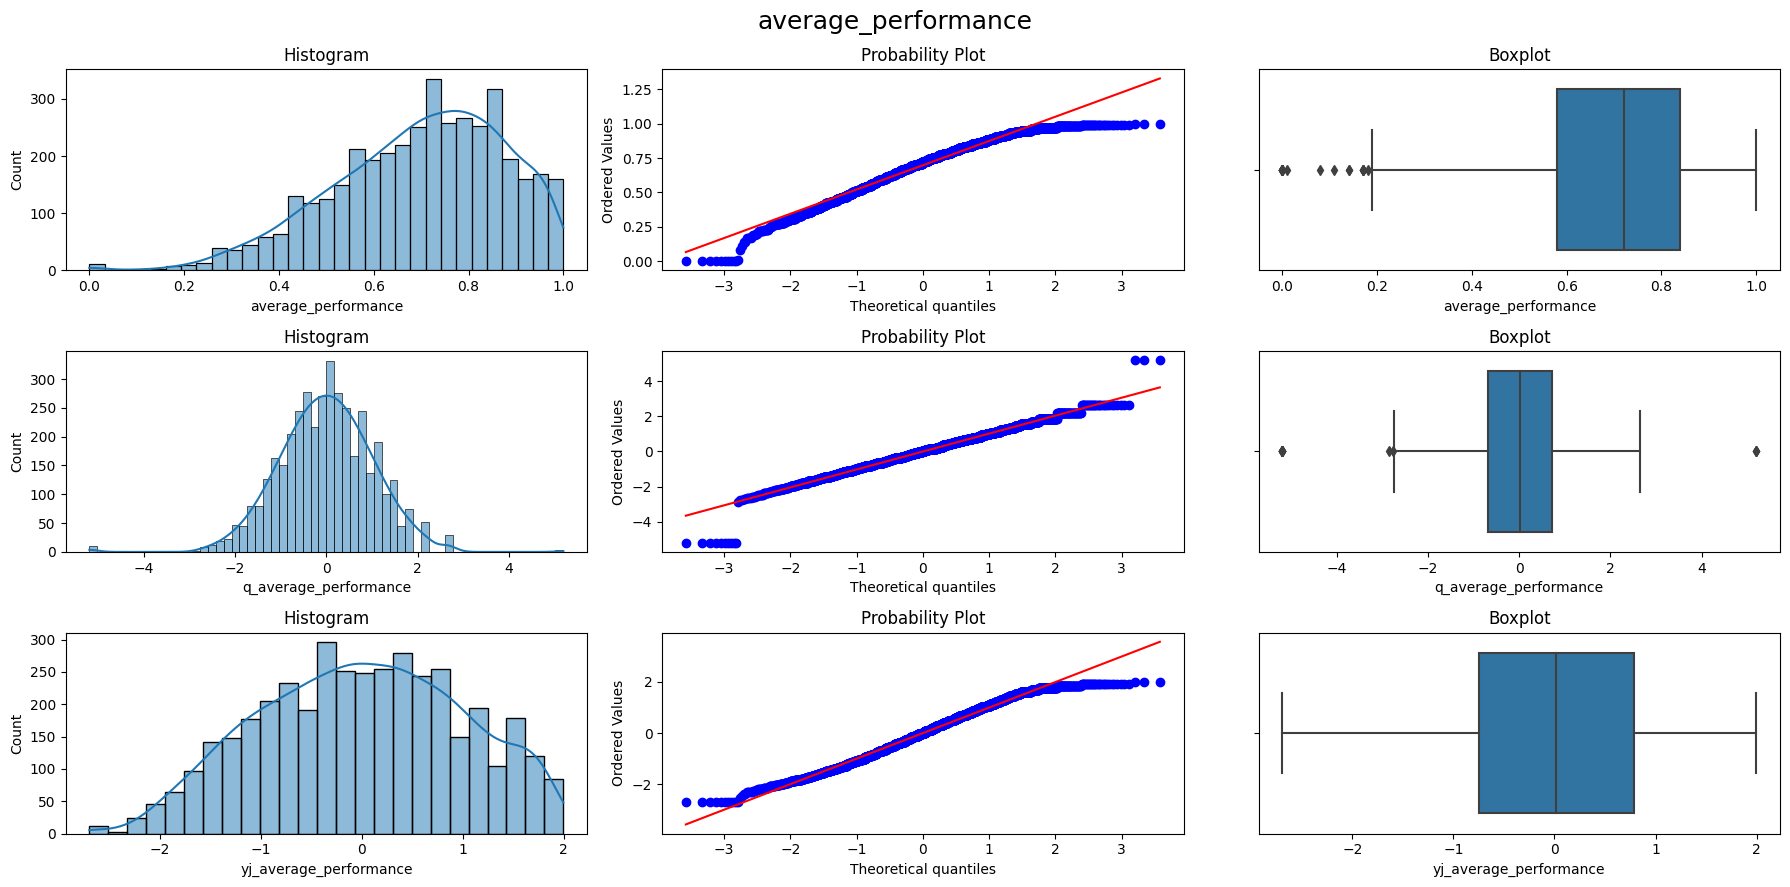

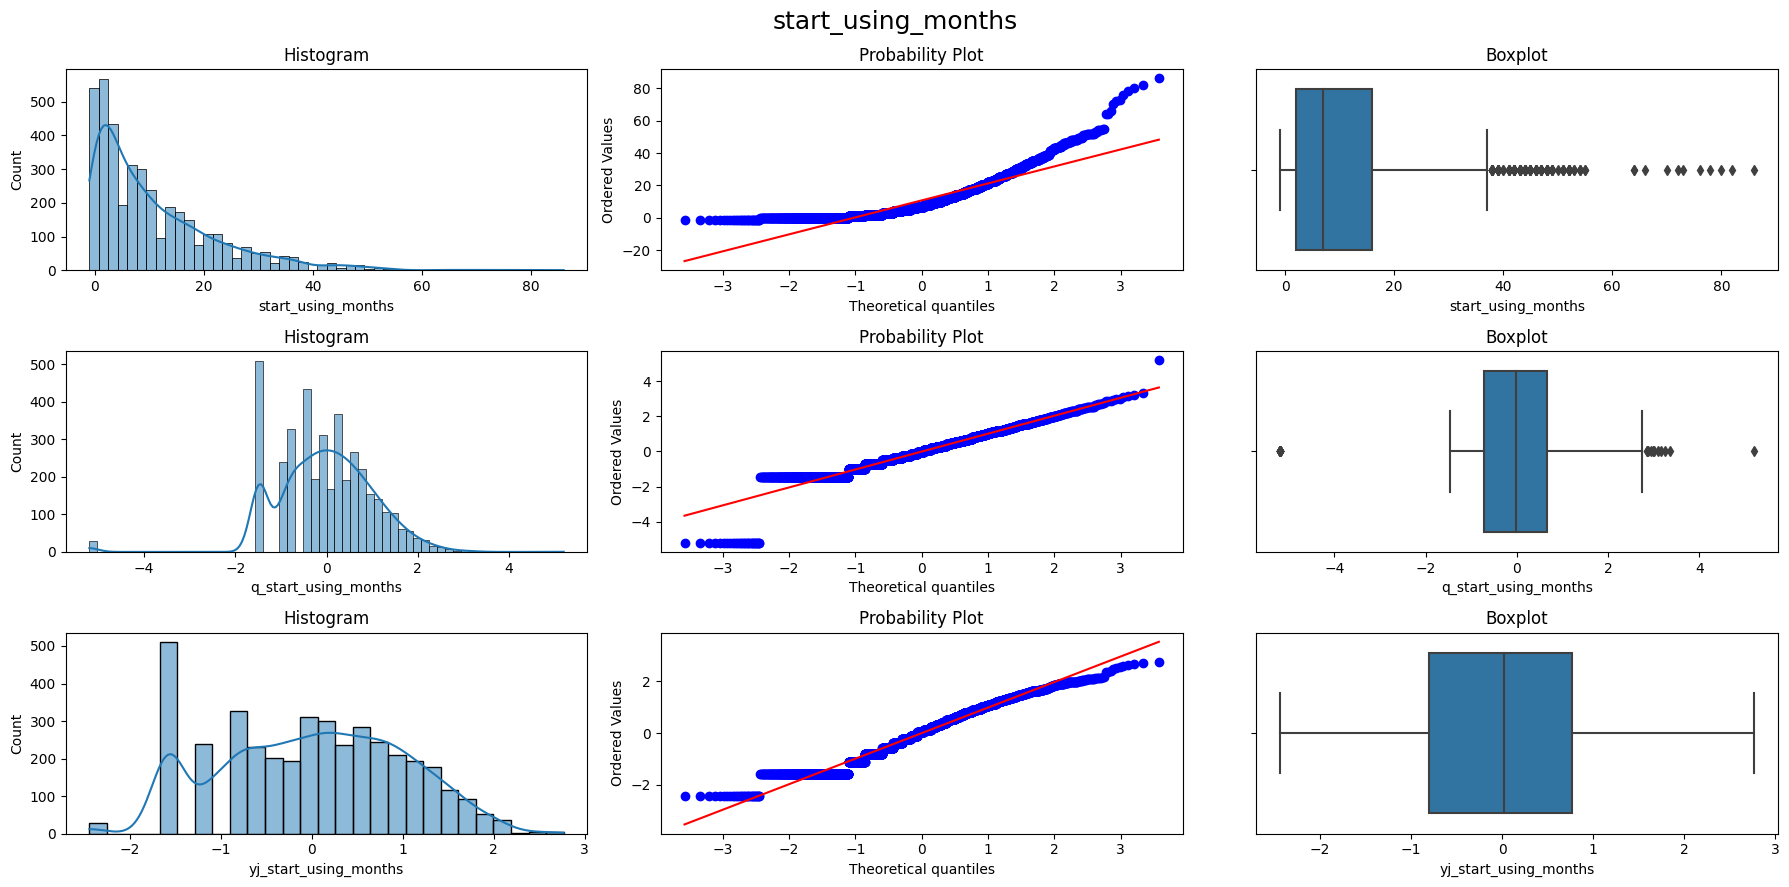

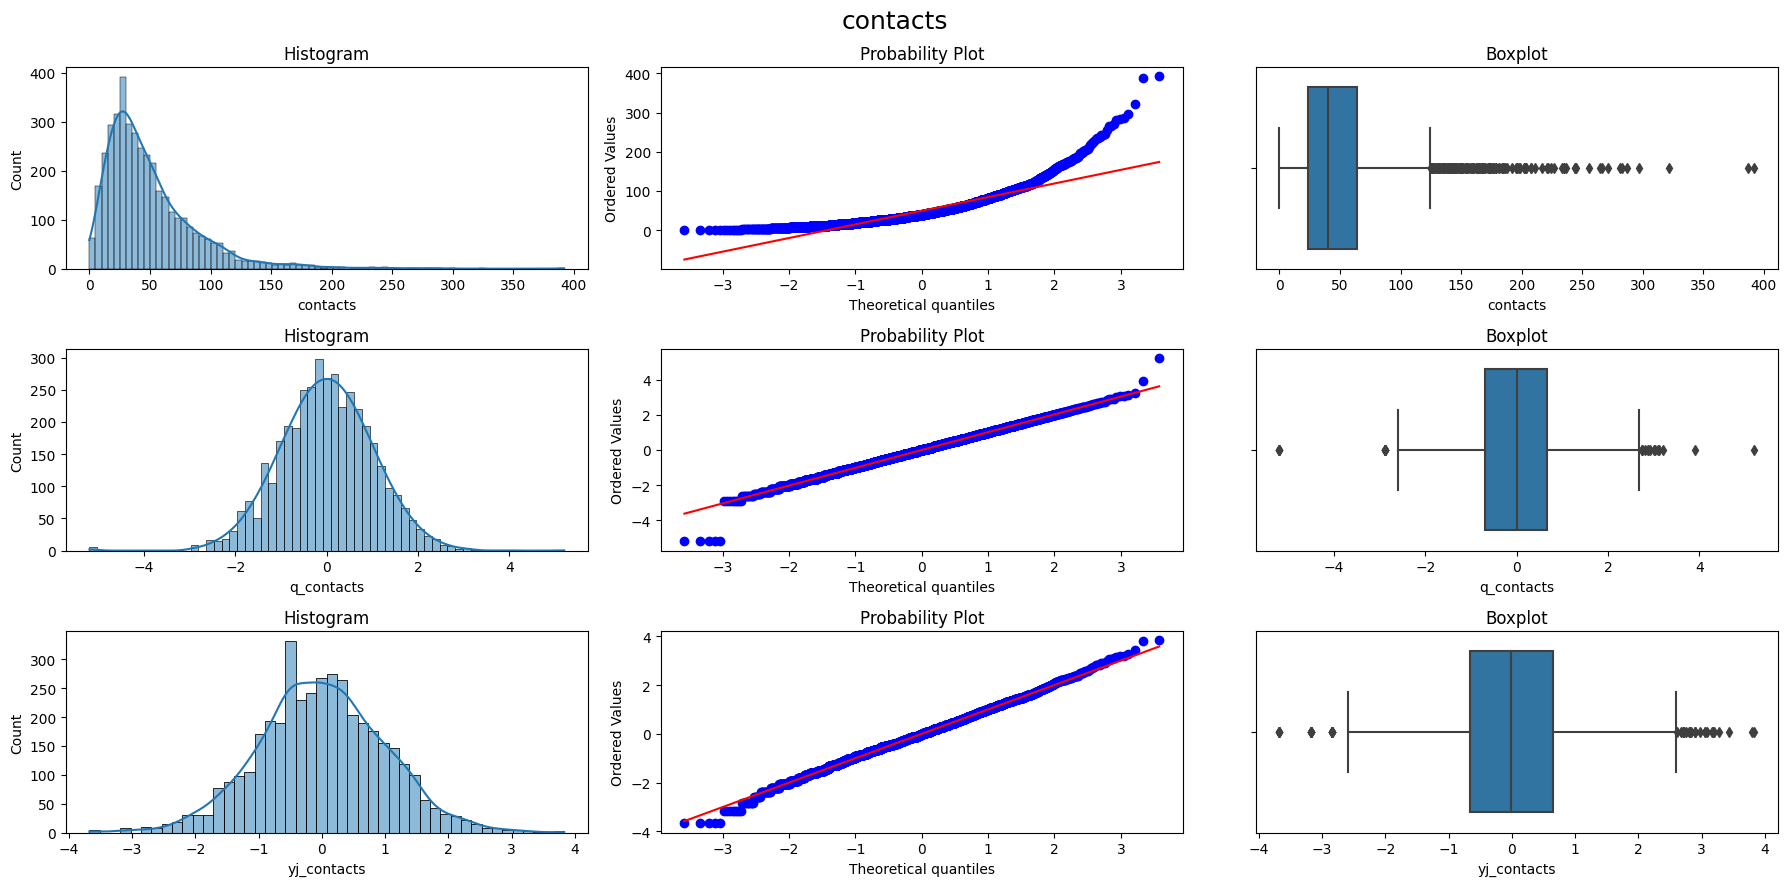

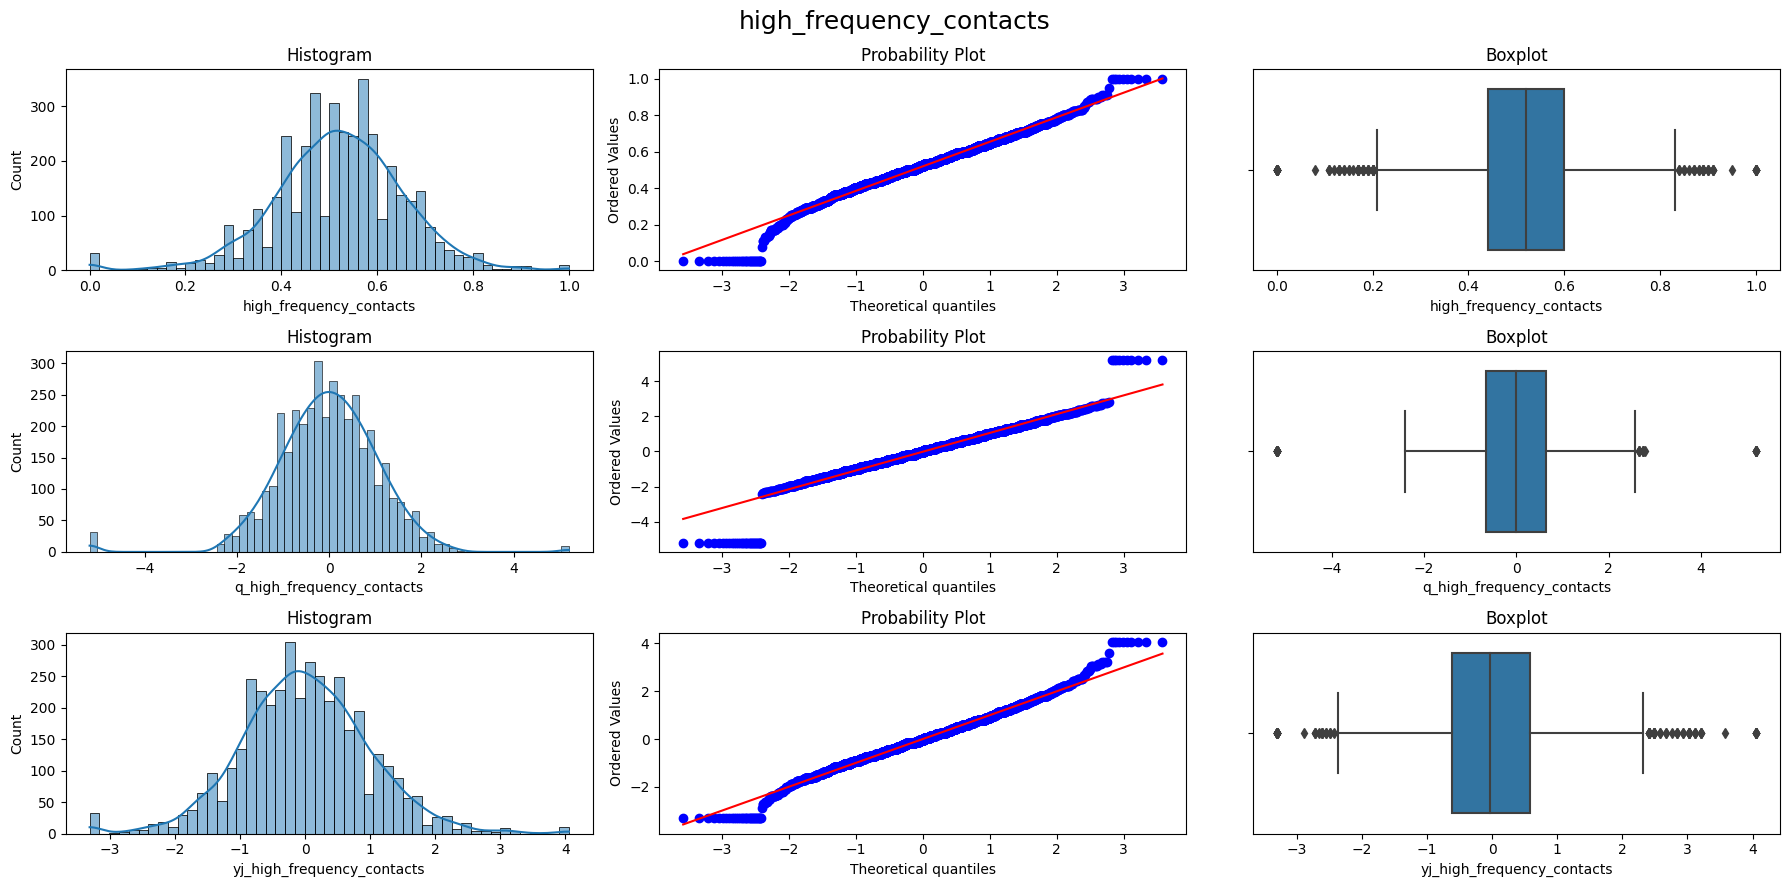

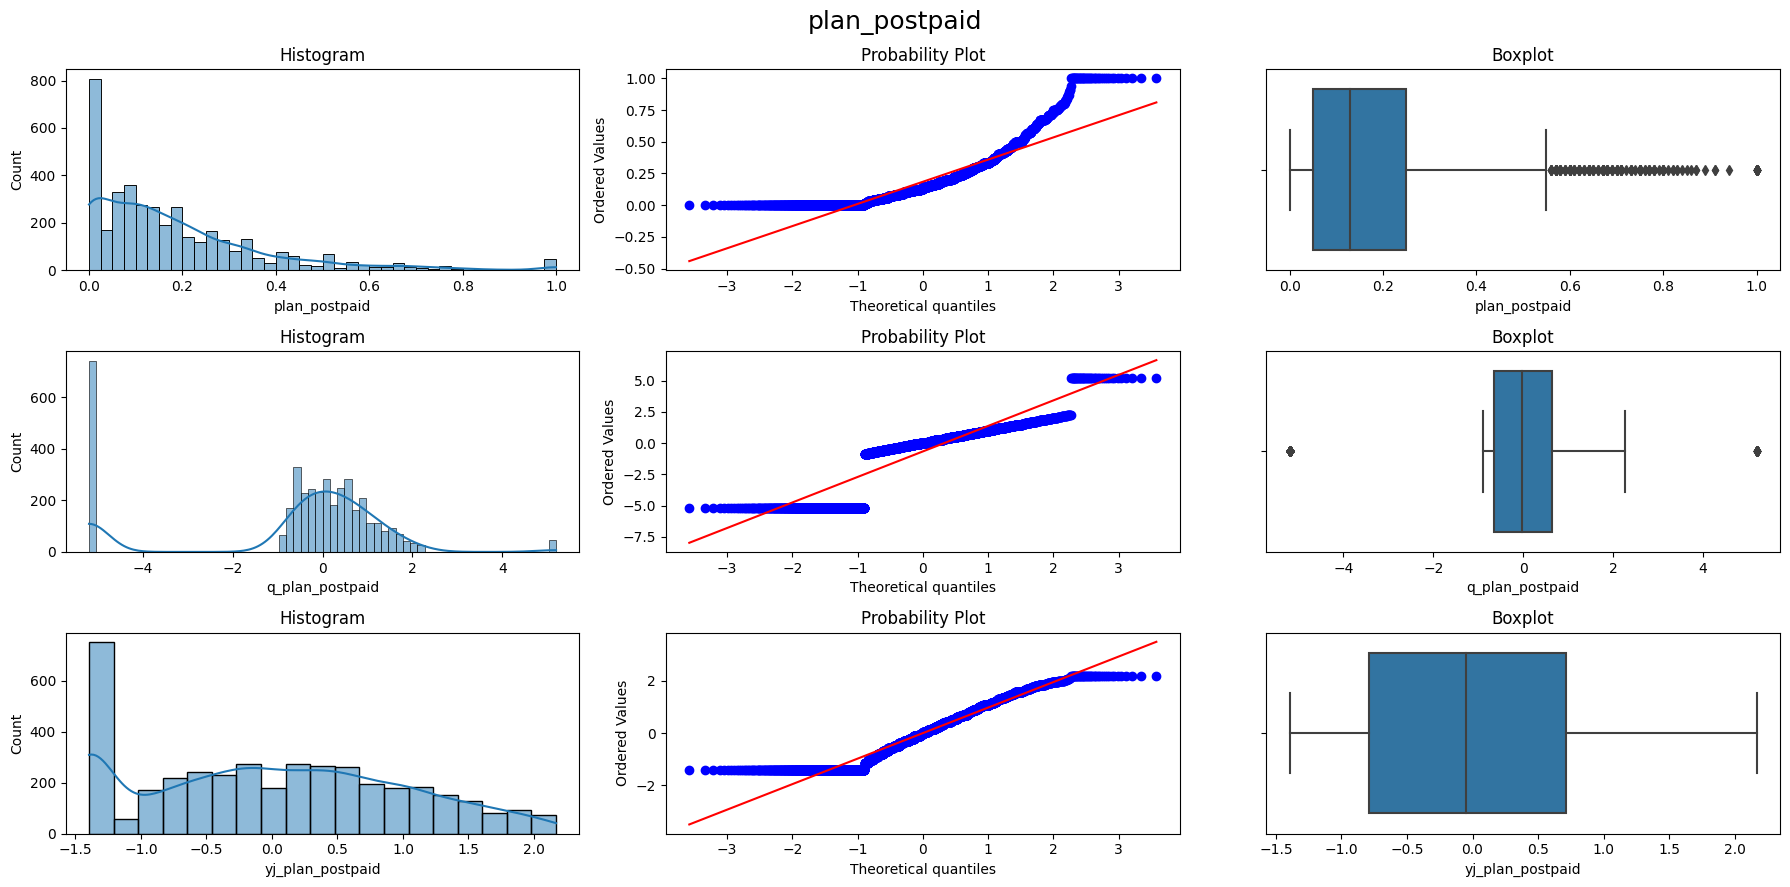

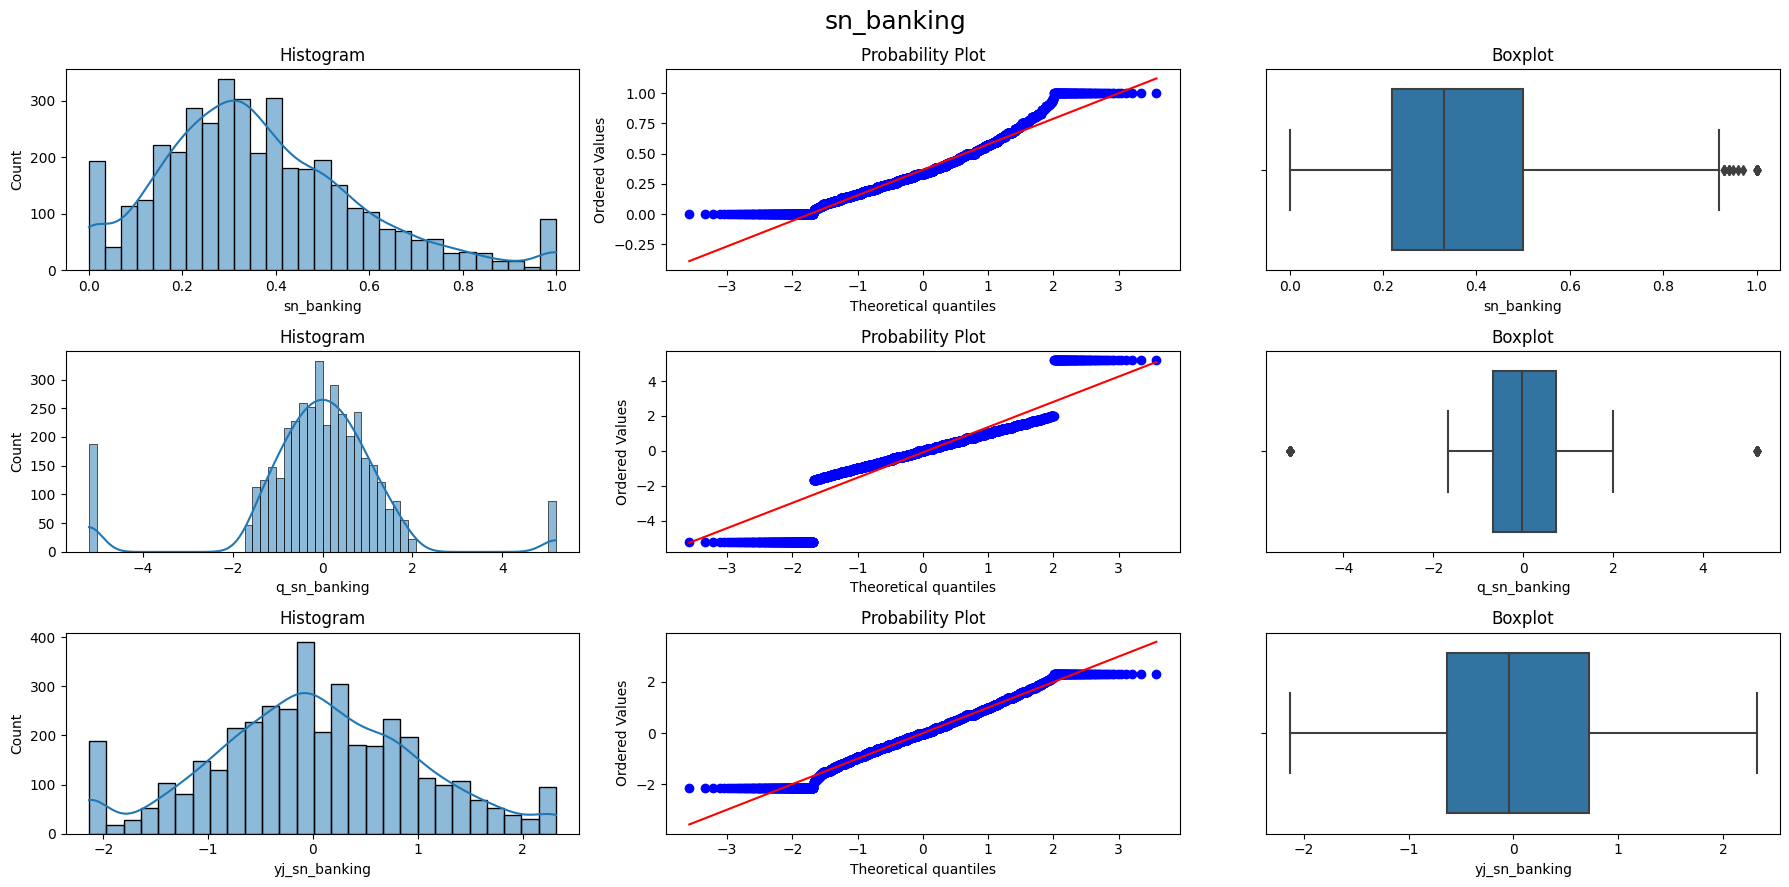

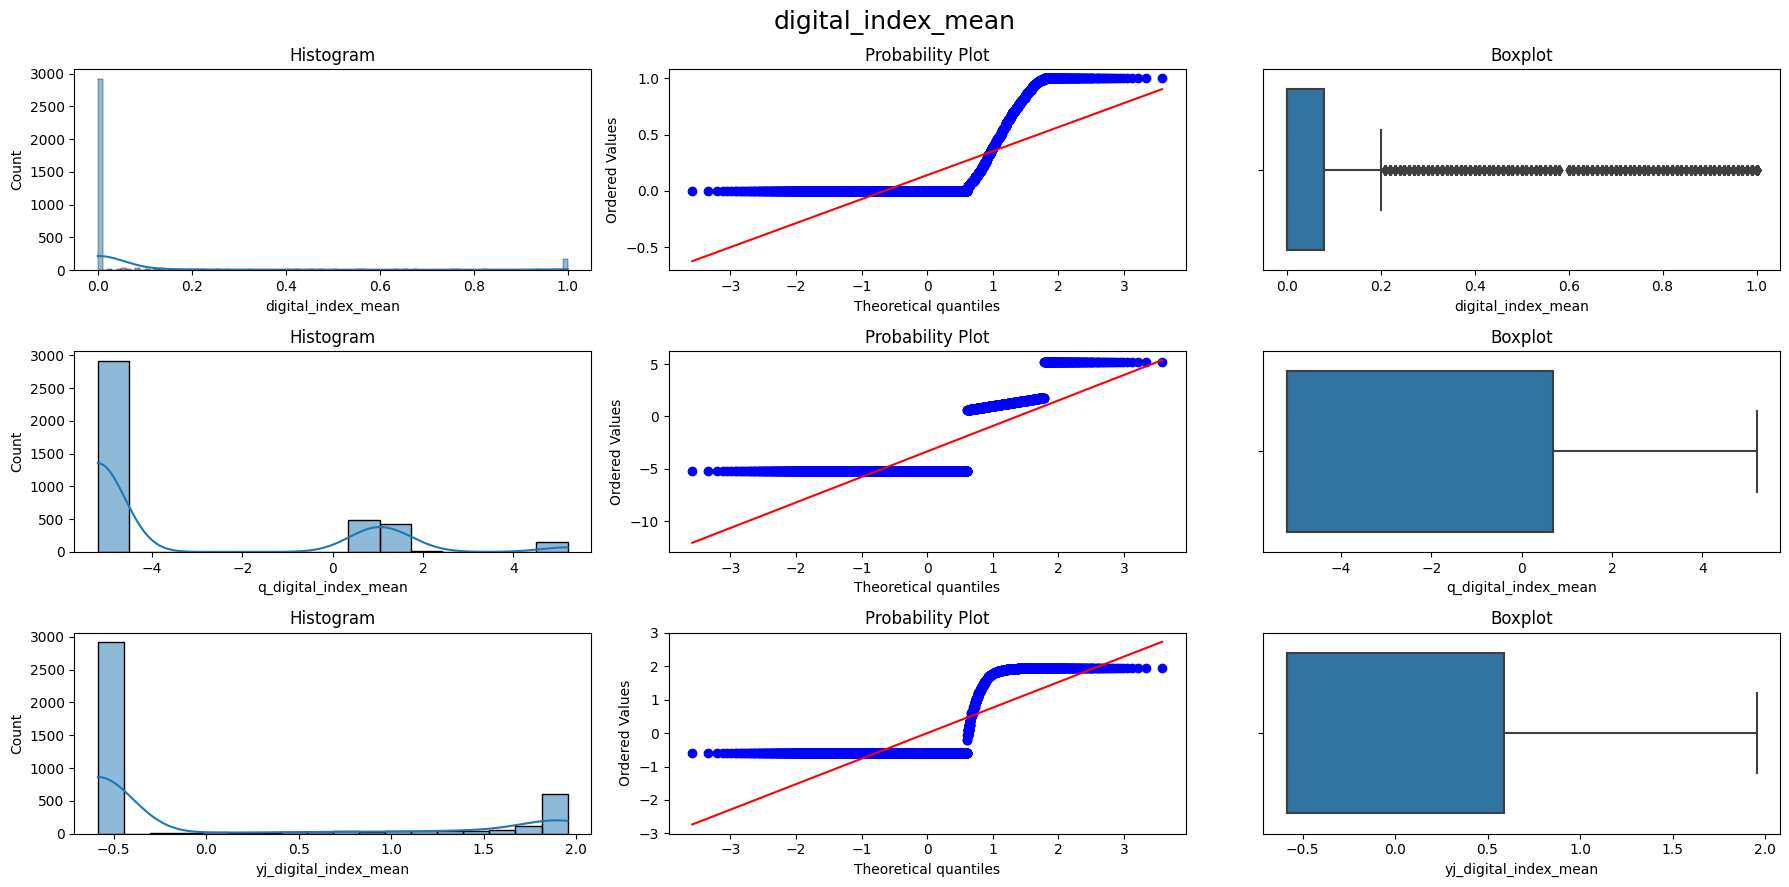

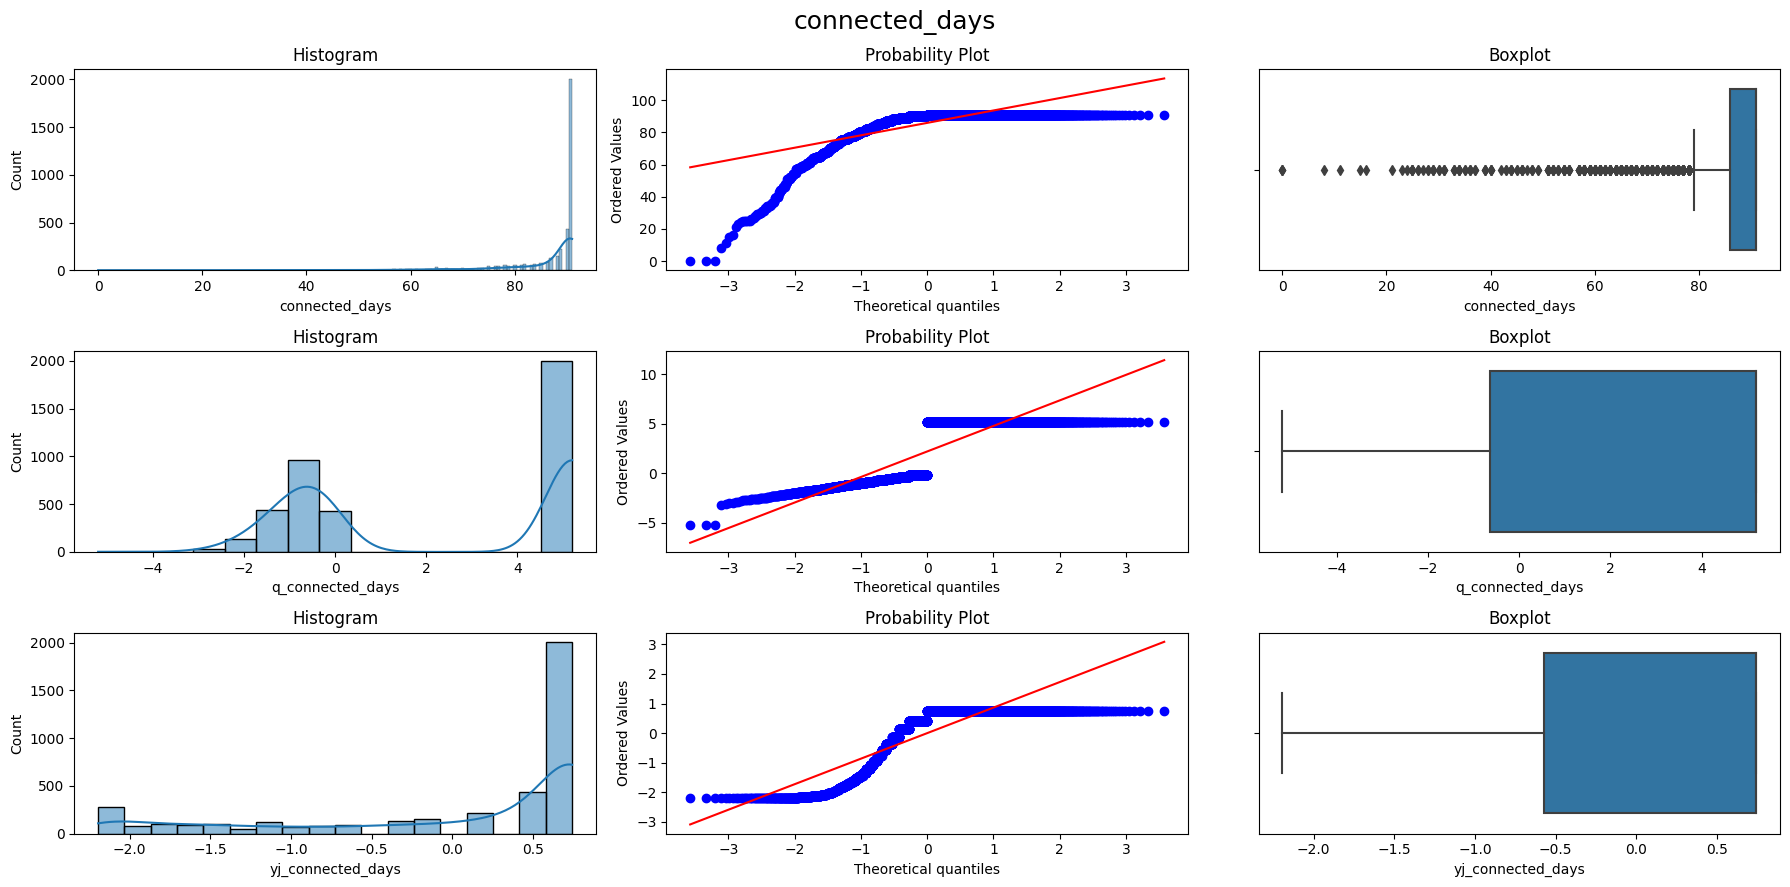

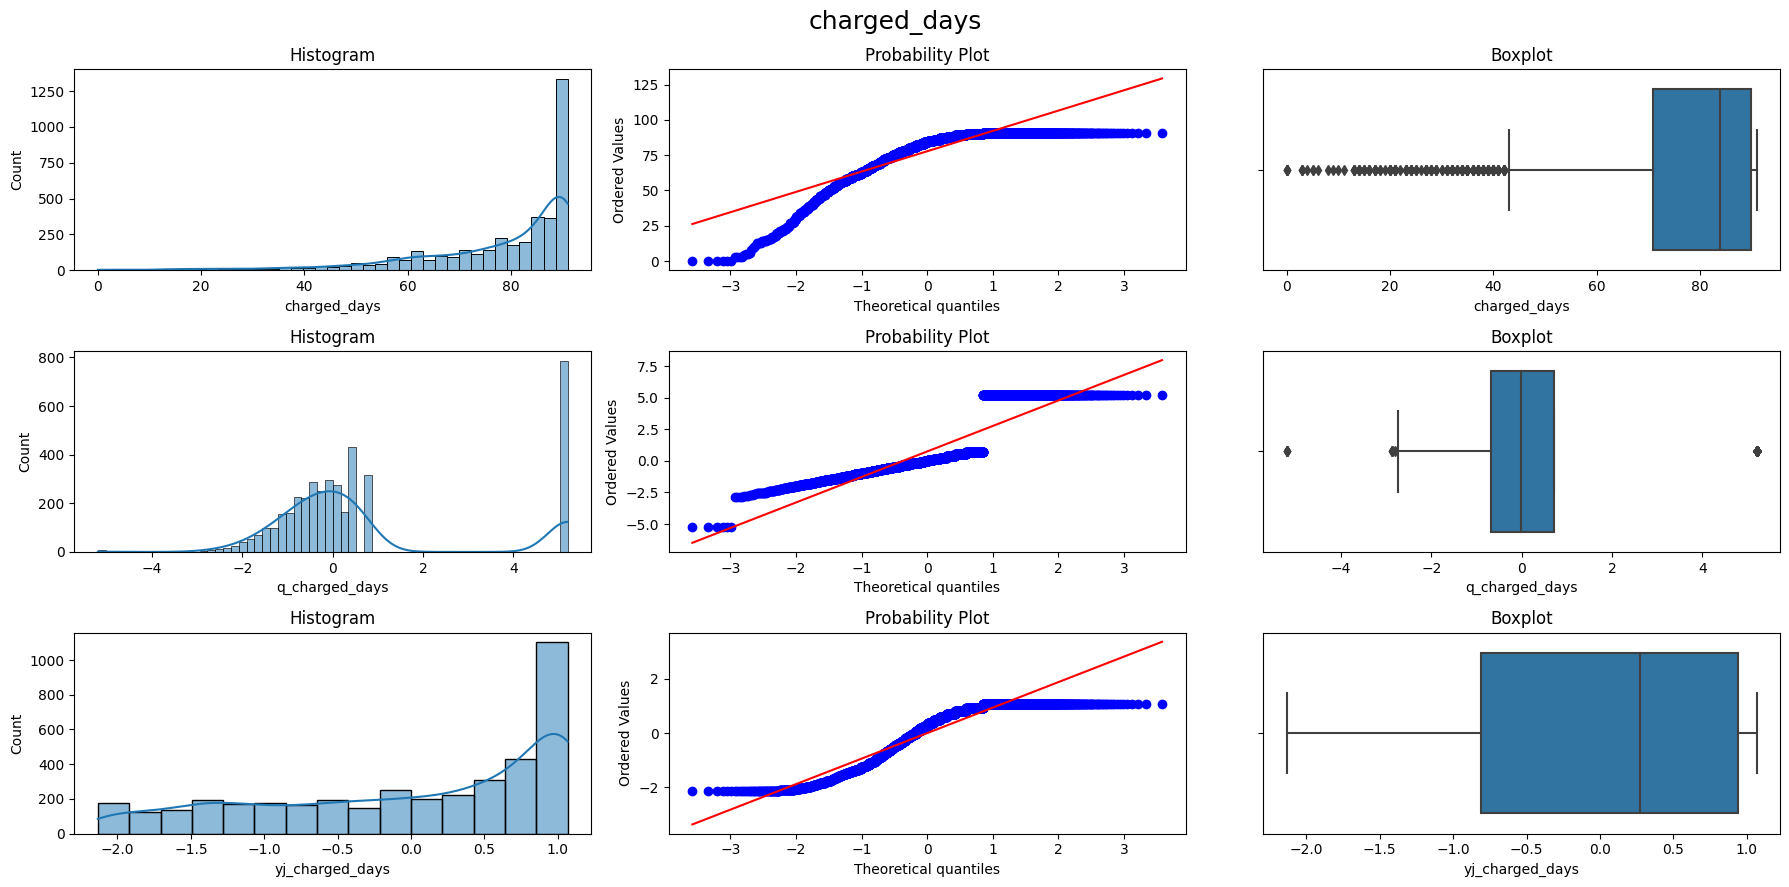

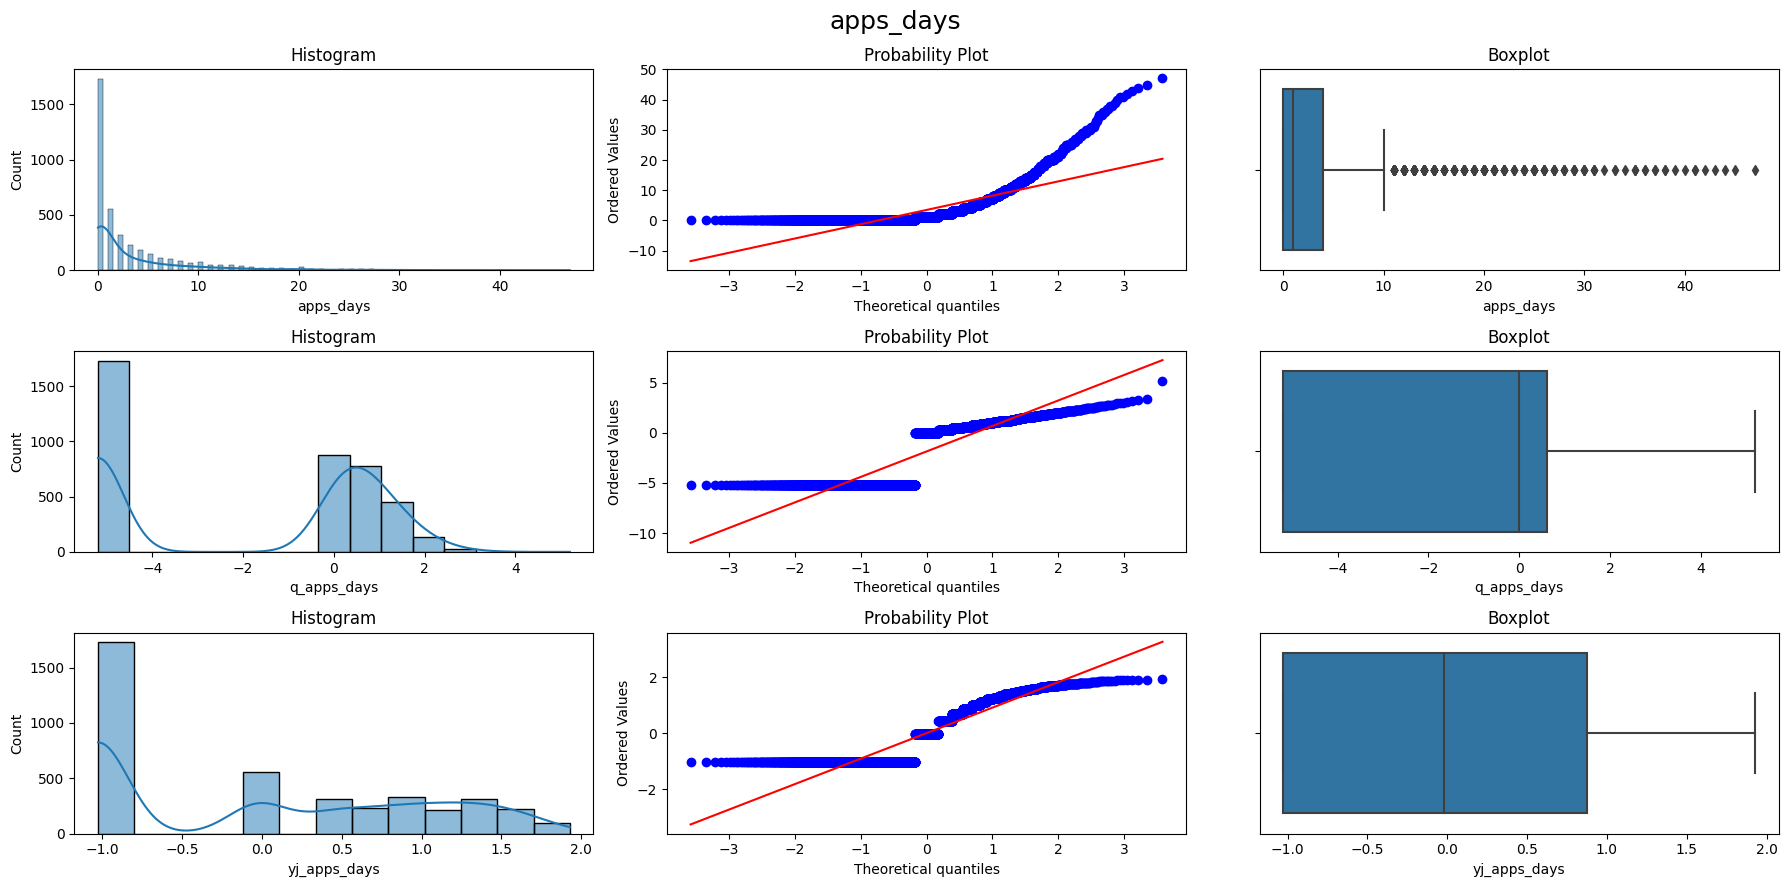

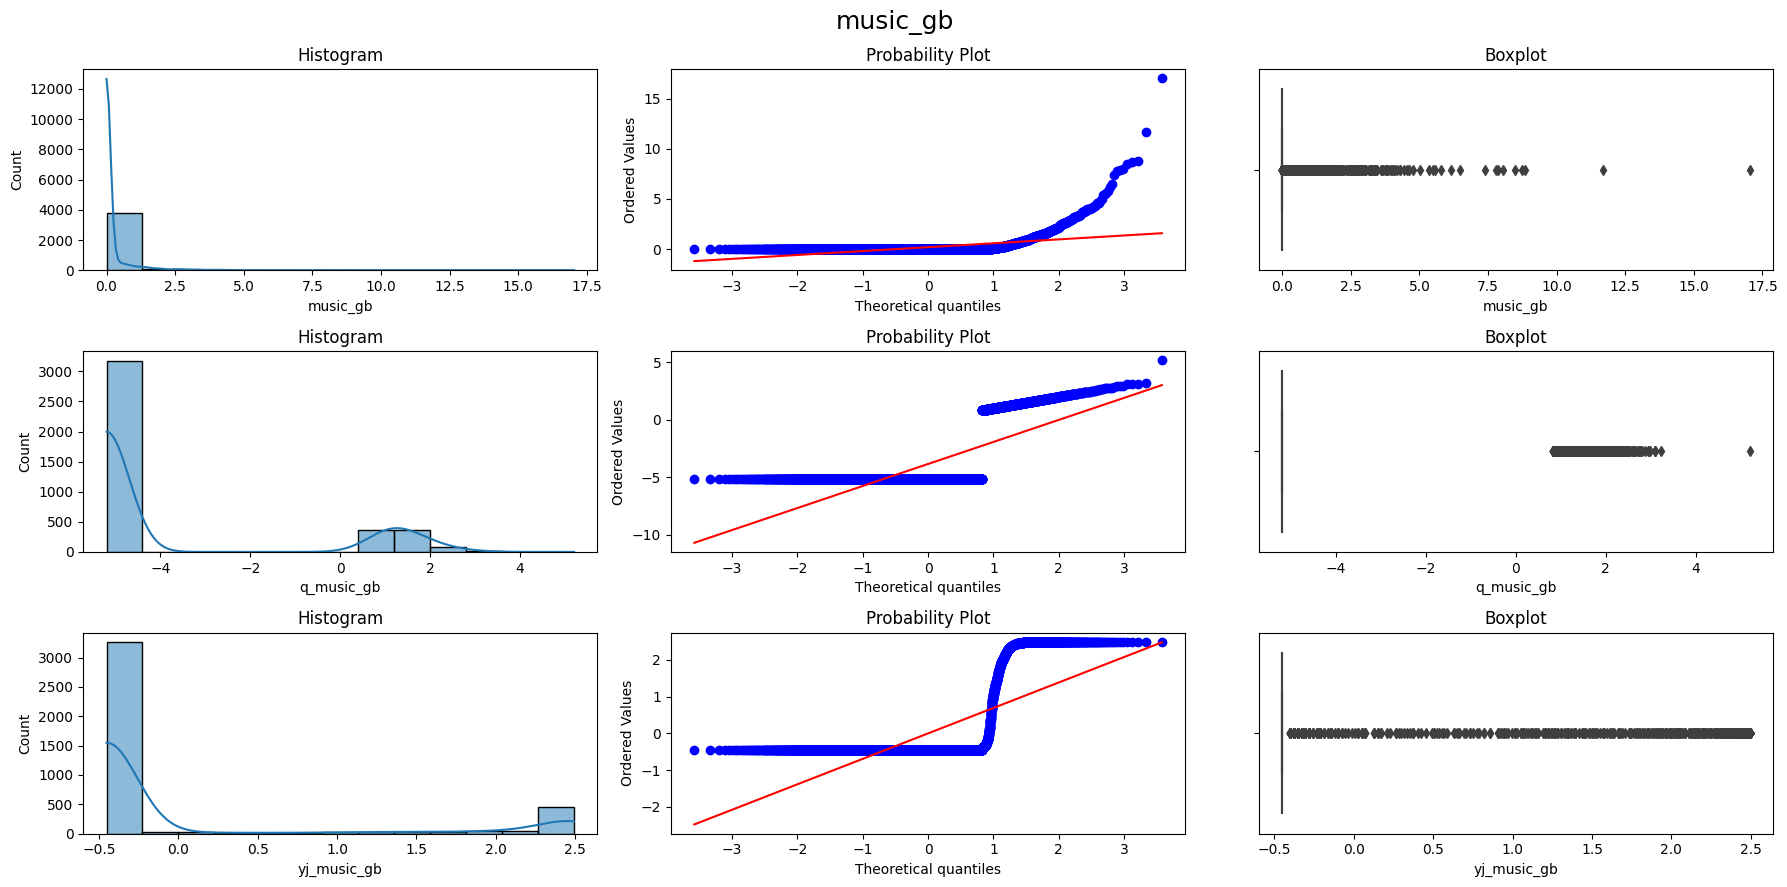

In [ ]:
df_train_sample = df_train.sample(4000)

for col in df_train_sample.columns[2:len(df_train_sample.columns)-1]:
    plot_hist_prob(df_train_sample, col)

## Resampling

In [ ]:
train_X, train_y = df_split(df_train)
test_X, test_y = df_split(df_test)

In [ ]:
train_X_resampled, train_y_resampled = under_sampling(train_X, train_y, ratio=0.85)

Revisar cómo quedó el remuestreo en el balance de las clases

In [ ]:
train_y.mean()

0.03736728968898838

In [ ]:
train_y_resampled.mean()

0.45946101577795695

Revisar el tamaño del dataset de entrenamiento

In [ ]:
train_X.shape

(427058, 20)

In [ ]:
train_X_resampled.shape

(34732, 20)

# Data Pipeline

* Cleaning
* Training

In [ ]:
train_X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34732 entries, 0 to 34731
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state_name               34732 non-null  object 
 1   previous_classification  34732 non-null  object 
 2   previous_calls           34732 non-null  int64  
 3   client_age               26720 non-null  float64
 4   network_age_years        34732 non-null  float64
 5   banking                  34732 non-null  int64  
 6   arpu_90_days             34732 non-null  float64
 7   minutes_in               34732 non-null  float64
 8   validity_average         34732 non-null  float64
 9   average_performance      34732 non-null  float64
 10  start_using_months       34729 non-null  float64
 11  contacts                 34732 non-null  int64  
 12  high_frequency_contacts  34732 non-null  float64
 13  plan_postpaid            34732 non-null  float64
 14  sn_banking            

In [ ]:
model = XGBClassifier(max_depth = 2, random_state=123)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

Entrenar transformaciones con todos los datos

In [ ]:
target_encoder_state = TargetEncoder()
target_encoder_state.fit(train_X['state_name'],train_y)

TargetEncoder(cols=['state_name'])

In [ ]:
client_age_median = train_X['client_age'].median()
network_age_years_median = train_X['network_age_years'].median()
start_using_months_median = train_X['start_using_months'].median()

In [ ]:
quantile_transform_features = ['client_age','network_age_years','arpu_90_days','minutes_in','validity_average','average_performance','contacts']

q_transformer = QuantileTransformer(output_distribution='normal')
q_transformer.fit(train_X[quantile_transform_features])

QuantileTransformer(output_distribution='normal')

In [ ]:
yj_transform_features = ['previous_calls','start_using_months','high_frequency_contacts','plan_postpaid','sn_banking','connected_days','charged_days','apps_days']

yj_transformer = PowerTransformer(method='yeo-johnson')
yj_transformer.fit(train_X[yj_transform_features])

PowerTransformer()

Definición del pipeline

In [ ]:
model_pipeline = Pipeline(steps=[
    # state_name: Target Encoder
    #('state_name_target_encoder', ExperimentalTransformer('state_name', 'apply_target_encoder'))
    ('state_name_target_encoder', ExperimentalTransformer('state_name', 'use_target_encoder', {'encoder':target_encoder_state}))
    # previous_classification: One Hot Encoder
    , ('previous_classification_one_hot_encoder', ExperimentalTransformer('previous_classification', 'apply_one_hot_encoder'))
    # client_age: set_nan_value fuera de 18-80, imputar con mediana
    , ('client_age_set_nan', ExperimentalTransformer('client_age', 'set_nan_value', {'min': 18, 'max': 80}))
    #, ('client_age_impute_nan', ExperimentalTransformer('client_age', 'impute_nan', {'metric': 'median', 'specific_value': None}))
    , ('client_age_impute_nan', ExperimentalTransformer('client_age', 'impute_nan', {'metric': 'specific', 'specific_value': client_age_median}))
    # network_age_years: imputar con mediana
    #, ('network_age_years_impute_nan', ExperimentalTransformer('network_age_years', 'impute_nan', {'metric': 'median', 'specific_value': None}))
    , ('network_age_years_impute_nan', ExperimentalTransformer('network_age_years', 'impute_nan', {'metric': 'specific', 'specific_value': network_age_years_median}))
    # minutes_in: truncar en 300
    , ('minutes_in_truncate', ExperimentalTransformer('minutes_in', 'column_truncate', {'upper_bound': 300, 'value': 300}))
    # average_performance: truncar en 1
    , ('average_performance_truncate', ExperimentalTransformer('average_performance', 'column_truncate', {'upper_bound': 1, 'value': 1}))
    # start_using_months: set_nan_value fuera de 0-94, imputar con mediana
    , ('start_using_months_set_nan', ExperimentalTransformer('start_using_months', 'set_nan_value', {'min': 0, 'max': 94}))
    #, ('start_using_months_impute_nan', ExperimentalTransformer('start_using_months', 'impute_nan', {'metric': 'median', 'specific_value': None}))
    , ('start_using_months_impute_nan', ExperimentalTransformer('start_using_months', 'impute_nan', {'metric': 'specific', 'specific_value': start_using_months_median}))
    # previous_calls: ninguna accion
    # banking: ninguna accion
    # arpu_90_days: ninguna accion
    # validity_average: ninguna accion
    # contacts: ninguna accion
    # high_frequency_contacts: ninguna accion
    # plan_postpaid: ninguna accion
    # sn_banking: ninguna accion
    # digital_index_mean: ninguna accion
    # connected_days: ninguna accion
    # charged_days: ninguna accion
    # apps_days: ninguna accion
    # music_gb: ninguna accion
    , ('quantile_transformations', ExperimentalTransformer(quantile_transform_features, 'apply_transformer', {'transformer': q_transformer}))
    , ('yeo_johnson_transformations', ExperimentalTransformer(yj_transform_features, 'apply_transformer', {'transformer': yj_transformer}))

    # debug
    , ("debug", Debug())

    # model
    , ('classifier', model)
])

In [ ]:
result = model_pipeline.fit(X=train_X_resampled, y=train_y_resampled)

Doing fit on feature  state_name
Doing transform on feature  state_name
Doing fit on feature  previous_classification
Doing transform on feature  previous_classification
Doing fit on feature  client_age
Doing transform on feature  client_age
Doing transform on feature  client_age  | lower bound: 18  | upper bound: 80
Doing fit on feature  client_age
 The value on impute_nan is: 40.0
Doing transform on feature  client_age
 The value on impute_nan is: 40.0
Doing fit on feature  network_age_years
 The value on impute_nan is: 2.53
Doing transform on feature  network_age_years
 The value on impute_nan is: 2.53
Doing fit on feature  minutes_in
Doing transform on feature  minutes_in
Doing fit on feature  average_performance
Doing transform on feature  average_performance
Doing fit on feature  start_using_months
Doing transform on feature  start_using_months
Doing transform on feature  start_using_months  | lower bound: 0  | upper bound: 94
Doing fit on feature  start_using_months
 The value o

In [ ]:
result

Pipeline(steps=[('state_name_target_encoder',
                 ExperimentalTransformer(feature_name='state_name',
                                         parameters={'encoder': TargetEncoder(cols=['state_name'])},
                                         transformation='use_target_encoder')),
                ('previous_classification_one_hot_encoder',
                 ExperimentalTransformer(feature_name='previous_classification',
                                         transformation='apply_one_hot_encoder')),
                ('client_age...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

In [ ]:
train_X_transformed = pd.read_csv('x.csv')

In [ ]:
train_X_transformed

state_name  previous_classification_NOT INTERESTED  \
0        0.044849                                       1   
1        0.032019                                       0   
2        0.042551                                       0   
3        0.032019                                       0   
4        0.040718                                       0   
...           ...                                     ...   
34727    0.044849                                       0   
34728    0.032019                                       0   
34729    0.042471                                       0   
34730    0.032019                                       1   
34731    0.032019                                       0   

       previous_classification_NEW CLIENT  \
0                                       0   
1                                       1   
2                                       1   
3                                       0   
4                                       0   
...                                   ...   
34727                                   0   
34728                                   0   
34729                                   1   
34730                                   0   
34731                                   1   

       previous_classification_NOT EFFECTIVE  previous_calls  client_age  \
0                                          0        0.756483    0.090452   
1                                          0       -1.146922    0.011291   
2                                          0       -1.146922    0.011291   
3                                          1        0.141891   -0.071571   
4                                          1        0.141891    1.435477   
...                                      ...             ...         ...   
34727                                      1        0.141891   -0.797044   
34728                                      1        0.141891    1.109378   
34729                                      0       -1.146922    0.011291   
34730                                      0        0.141891   -0.149853   
34731                                      0       -1.146922    1.625274   

       network_age_years  banking  arpu_90_days  minutes_in  ...  \
0              -0.627196        1      1.891091    0.002836  ...   
1              -1.606755        0      2.051601    0.299991  ...   
2              -0.337506        1      3.150251    0.307540  ...   
3              -1.081940        0     -0.651824   -0.885985  ...   
4               0.709180        1     -0.797044   -0.364191  ...   
...                  ...      ...           ...         ...  ...   
34727          -0.114415        1     -0.590650    1.849332  ...   
34728           2.141846        1      1.120395    0.682234  ...   
34729          -1.040090        1     -0.595437    0.736720  ...   
34730          -0.103057        1     -0.543789   -1.767903  ...   
34731          -0.011291        1      2.534049   -1.193349  ...   

       start_using_months  contacts  high_frequency_contacts  plan_postpaid  \
0                0.027311 -0.177827                 1.284758      -1.414035   
1               -0.571819 -0.795322                -0.708361      -1.414035   
2                0.493837  0.633317                 1.122551      -0.705836   
3               -0.094003 -1.292465                 1.122551       0.220364   
4               -1.567259 -1.084195                -0.196600      -0.412416   
...                   ...       ...                      ...            ...   
34727            1.047643  0.373591                 0.723455       1.974537   
34728           -0.799323  0.979511                -1.407060      -0.811871   
34729           -1.100588  0.607463                -0.418195       0.286821   
34730            0.493837 -1.365257                 2.117625       0.880332   
34731            1.144406 -1.517545                -0.196600       0.923922   

       sn_banking  digital_index_mean  connected_days 

# Evaluate Train

In [ ]:
train_y_predicted = result.predict_proba(train_X)[:,1]

Doing transform on feature  state_name
Doing transform on feature  previous_classification
Doing transform on feature  client_age
Doing transform on feature  client_age  | lower bound: 18  | upper bound: 80
Doing transform on feature  client_age
 The value on impute_nan is: 40.0
Doing transform on feature  network_age_years
 The value on impute_nan is: 2.53
Doing transform on feature  minutes_in
Doing transform on feature  average_performance
Doing transform on feature  start_using_months
Doing transform on feature  start_using_months  | lower bound: 0  | upper bound: 94
Doing transform on feature  start_using_months
 The value on impute_nan is: 7.0
Doing transform on feature  ['client_age', 'network_age_years', 'arpu_90_days', 'minutes_in', 'validity_average', 'average_performance', 'contacts']
Doing transform on feature  ['previous_calls', 'start_using_months', 'high_frequency_contacts', 'plan_postpaid', 'sn_banking', 'connected_days', 'charged_days', 'apps_days']
(427058, 22)


In [ ]:
threshold_metrics = threshold_iter(train_y, train_y_predicted, min=0, max=1, step=0.05)
threshold_metrics_df = pd.DataFrame(threshold_metrics)
threshold_metrics_df

Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


threshold  positive_prediction  precision    recall        f1 support  \
0        0.00             1.000000   0.037367  1.000000  0.072043    None   
1        0.05             0.999897   0.037371  1.000000  0.072050    None   
2        0.10             0.997874   0.037440  0.999812  0.072177    None   
3        0.15             0.986828   0.037814  0.998621  0.072868    None   
4        0.20             0.949740   0.039009  0.991478  0.075065    None   
5        0.25             0.877530   0.041256  0.968856  0.079142    None   
6        0.30             0.776546   0.044507  0.924928  0.084928    None   
7        0.35             0.659440   0.048587  0.857438  0.091963    None   
8        0.40             0.533579   0.054022  0.771400  0.100973    None   
9        0.45             0.410516   0.060280  0.662238  0.110502    None   
10       0.50             0.297524   0.068039  0.541735  0.120894    None   
11       0.55             0.199842   0.077838  0.416280  0.131152    None   
12       0.60             0.122438   0.091283  0.299098  0.139876    None   
13       0.65             0.067476   0.105428  0.190375  0.135704    None   
14       0.70             0.032005   0.120208  0.102958  0.110916    None   
15       0.75             0.012085   0.140477  0.045432  0.068659    None   
16       0.80             0.003323   0.183932  0.016355  0.030040    None   
17       0.85             0.000482   0.242718  0.003133  0.006187    None   
18       0.90             0.000009   0.000000  0.000000  0.000000    None   
19       0.95             0.000000   0.000000  0.000000  0.000000    None   

        tn      fp     fn     tp  
0        0  411100      0  15958  
1       44  411056      0  15958  
2      905  410195      3  15955  
3     5603  405497     22  15936  
4    21328  389772    136  15822  
5    51805  359295    497  15461  
6    94230  316870   1198  14760  
7   143164  267936   2275  13683  
8   195541  215559   3648  12310  
9   246354  164746   5390  10568  
10  292685  118415   7313   8645  
11  332399   78701   9315   6643  
12  363585   47515  11185   4773  
13  385322   25778  12920   3038  
14  399075   12025  14315   1643  
15  406664    4436  15233    725  
16  409942    1158  15697    261  
17  410944     156  15908     50  
18  411096       4  15958      0  
19  411100       0  15958      0

# Evaluate Test

In [ ]:
test_y_predicted = result.predict_proba(test_X)[:,1]

Doing transform on feature  state_name
Doing transform on feature  previous_classification
Doing transform on feature  client_age
Doing transform on feature  client_age  | lower bound: 18  | upper bound: 80
Doing transform on feature  client_age
 The value on impute_nan is: 40.0
Doing transform on feature  network_age_years
 The value on impute_nan is: 2.53
Doing transform on feature  minutes_in
Doing transform on feature  average_performance
Doing transform on feature  start_using_months
Doing transform on feature  start_using_months  | lower bound: 0  | upper bound: 94
Doing transform on feature  start_using_months
 The value on impute_nan is: 7.0
Doing transform on feature  ['client_age', 'network_age_years', 'arpu_90_days', 'minutes_in', 'validity_average', 'average_performance', 'contacts']
Doing transform on feature  ['previous_calls', 'start_using_months', 'high_frequency_contacts', 'plan_postpaid', 'sn_banking', 'connected_days', 'charged_days', 'apps_days']
(183025, 22)


In [ ]:
test_y_predicted

array([0.68304044, 0.57362396, 0.34423575, ..., 0.38282302, 0.38104215,
       0.38109985], dtype=float32)

array([[<Axes: title={'center': '0'}>]], dtype=object)

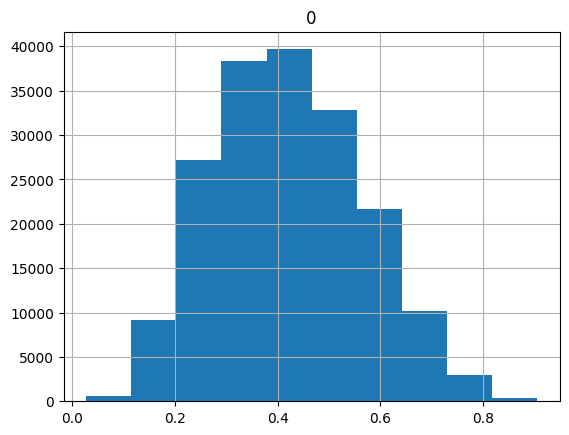

In [ ]:
pd.DataFrame(test_y_predicted).hist()

In [ ]:
test_X_transformed = pd.read_csv('x.csv')

In [ ]:
test_X_transformed

state_name  previous_classification_NOT INTERESTED  \
0         0.044849                                       0   
1         0.041623                                       1   
2         0.046469                                       0   
3         0.043204                                       0   
4         0.029995                                       0   
...            ...                                     ...   
183020    0.044849                                       0   
183021    0.030993                                       0   
183022    0.041623                                       0   
183023    0.041623                                       1   
183024    0.034824                                       0   

        previous_classification_NEW CLIENT  \
0                                        1   
1                                        0   
2                                        1   
3                                        0   
4                                        1   
...                                    ...   
183020                                   1   
183021                                   1   
183022                                   0   
183023                                   0   
183024                                   0   

        previous_classification_NOT EFFECTIVE  previous_calls  client_age  \
0                                           0       -1.146922   -1.149742   
1                                           0        0.756483    0.333524   
2                                           0       -1.146922   -0.071571   
3                                           1        0.141891   -0.071571   
4                                           0       -1.146922    1.236652   
...                                       ...             ...         ...   
183020                                      0       -1.146922    0.090452   
183021                                      0       -1.146922   -0.229064   
183022                                      1        0.141891    1.295363   
183023                                      0        1.410797    0.011291   
183024                                      1        0.756483   -0.797044   

        network_age_years  banking  arpu_90_days  minutes_in  ...  \
0                0.410214        1      1.895514   -0.187237  ...   
1                1.606755        1     -0.539431   -0.765968  ...   
2                0.129582        1     -0.401426   -1.745146  ...   
3                1.641774        1     -1.923711    1.072570  ...   
4                1.438089        0     -1.096318   -1.508532  ...   
...                   ...      ...           ...         ...  ...   
183020          -1.174387        0     -0.630254    1.711541  ...   
183021          -0.580524        1      0.681985   -1.040429  ...   
183022          -0.540882        0      0.908063    1.849332  ...   
183023          -0.157469        1      1.047901   -0.134650  ...   
183024           0.089192        0      0.108099    1.849332  ...   

        start_using_months  contacts  high_frequency_contacts  plan_postpaid  \
0                -0.799323 -1.873053                 0.802538       1.869874   
1                 0.568708  1.130517                -0.851165       0.529697   
2                -1.567259  0.081638                 0.410817       0.638714   
3                -0.571819  0.633317                -0.046990       0.079803   
4                -0.094003 -0.965420                -1.270395      -1.414035   
...                    ...       ...                      ...            ...   
183020           -0.799323 -0.733156                 0.104119       0.690421   
183021            0.639315 -0.432104                -0.708361      -1.414035   
183022           -0.799323 -0.216204                -0.121983      -0.604052   
183023            0.236667  1.037937                -0.344707      -0.922378   
183024           -0.571819  0.373591                 0.028378      -0.922378

In [ ]:
threshold_metrics = threshold_iter(test_y, test_y_predicted, min=0, max=1, step=0.05)
threshold_metrics_df = pd.DataFrame(threshold_metrics)
threshold_metrics_df

Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


threshold  positive_prediction  precision    recall        f1 support  \
0        0.00             1.000000   0.037798  1.000000  0.072843    None   
1        0.05             0.999918   0.037801  1.000000  0.072849    None   
2        0.10             0.998120   0.037853  0.999566  0.072943    None   
3        0.15             0.987231   0.038193  0.997543  0.073569    None   
4        0.20             0.950122   0.039305  0.988002  0.075603    None   
5        0.25             0.878869   0.041379  0.962128  0.079345    None   
6        0.30             0.778637   0.044453  0.915727  0.084790    None   
7        0.35             0.660620   0.048507  0.847788  0.091764    None   
8        0.40             0.534665   0.053680  0.759324  0.100272    None   
9        0.45             0.410299   0.059511  0.645996  0.108983    None   
10       0.50             0.297200   0.066679  0.524284  0.118311    None   
11       0.55             0.199115   0.075158  0.395924  0.126335    None   
12       0.60             0.120967   0.083785  0.268141  0.127676    None   
13       0.65             0.066384   0.095885  0.168401  0.122194    None   
14       0.70             0.031471   0.107292  0.089332  0.097492    None   
15       0.75             0.011556   0.128605  0.039318  0.060224    None   
16       0.80             0.003185   0.157804  0.013299  0.024530    None   
17       0.85             0.000546   0.250000  0.003614  0.007125    None   
18       0.90             0.000022   0.000000  0.000000  0.000000    None   
19       0.95             0.000000   0.000000  0.000000  0.000000    None   

        tn      fp    fn    tp  
0        0  176107     0  6918  
1       15  176092     0  6918  
2      341  175766     3  6915  
3     2320  173787    17  6901  
4     9046  167061    83  6835  
5    21908  154199   262  6656  
6    39932  136175   583  6335  
7    61062  115045  1053  5865  
8    83503   92604  1665  5253  
9   105481   70626  2449  4469  
10  125339   50768  3291  3627  
11  142403   33704  4179  2739  
12  155822   20285  5063  1855  
13  165122   10985  5753  1165  
14  170965    5142  6300   618  
15  174264    1843  6646   272  
16  175616     491  6826    92  
17  176032      75  6893    25  
18  176103       4  6918     0  
19  176107       0  6918     0

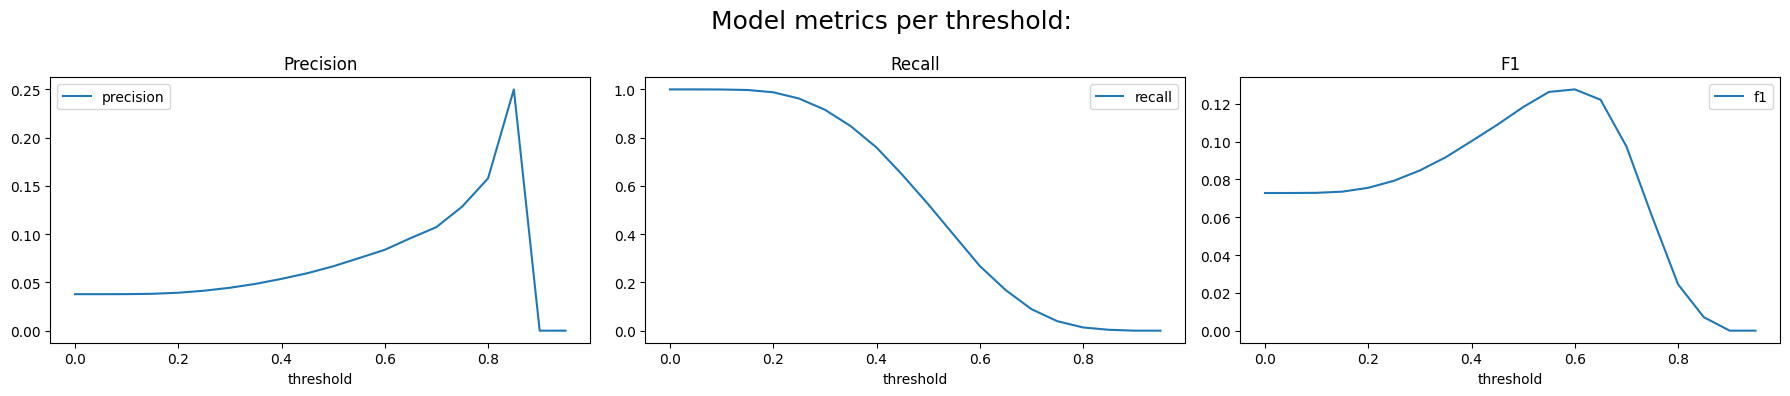

In [ ]:
plot_threshold_metrics(threshold_metrics_df)

# Model Explainability

In [ ]:
shap_values_sel_model = evaluate_shap_values(
    model=model,
    X_test=test_X_transformed.sample(5000),
    plot=False)

[05:03:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


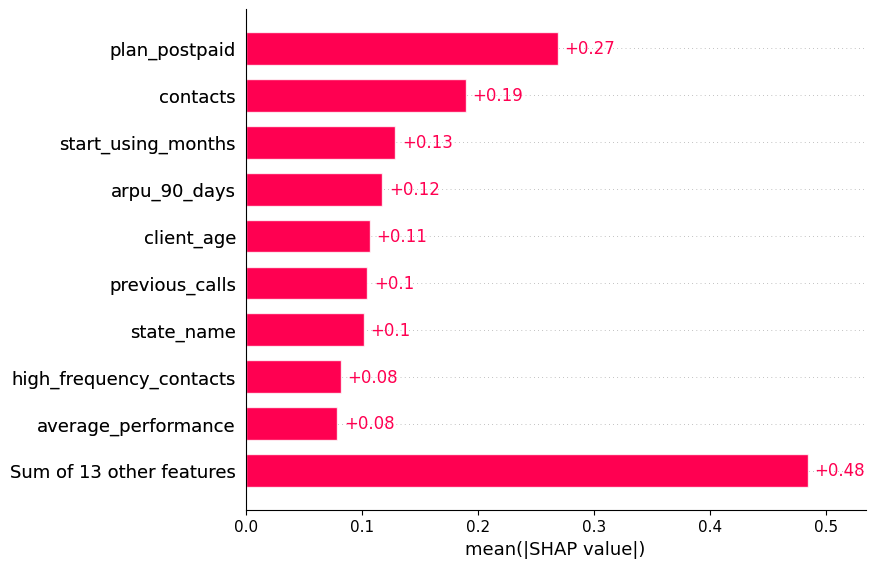

In [ ]:
shap.plots.bar(shap_values_sel_model)

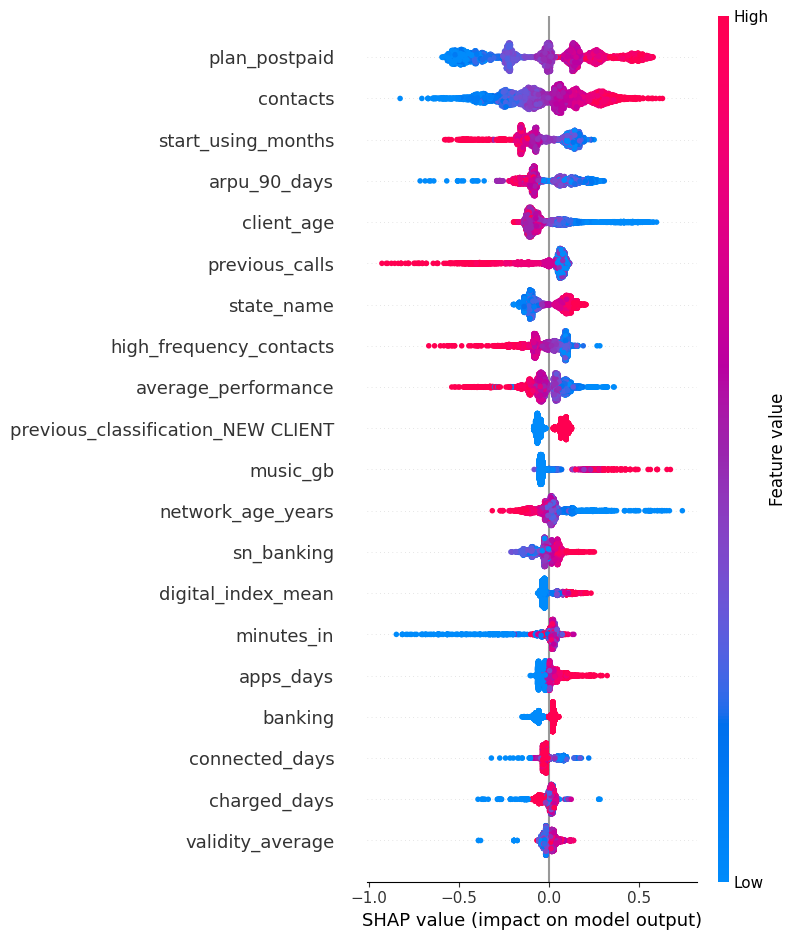

In [ ]:
shap.summary_plot(shap_values_sel_model)

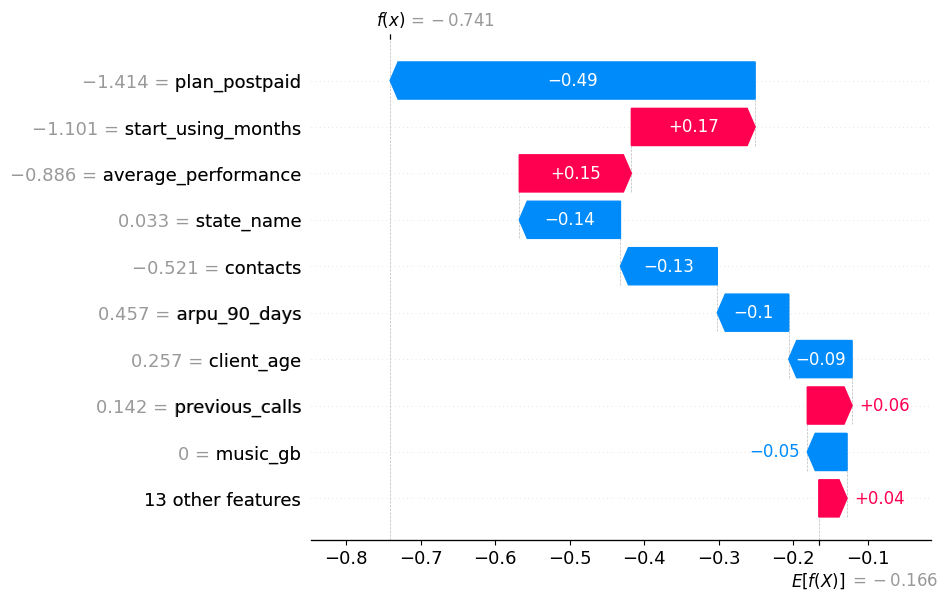

In [ ]:
shap.plots.waterfall(shap_values_sel_model[0])

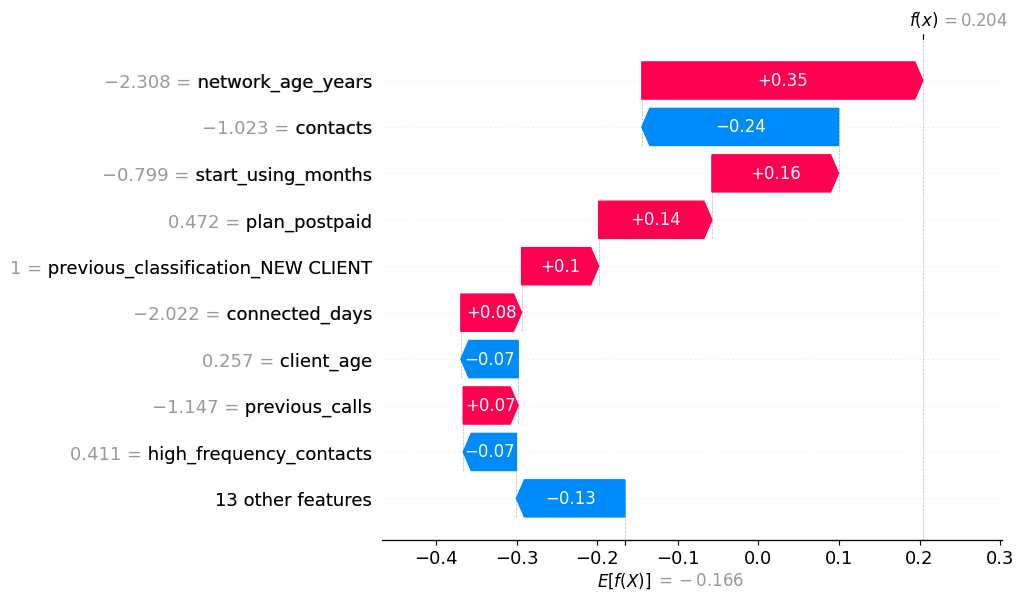

In [ ]:
shap.plots.waterfall(shap_values_sel_model[1])

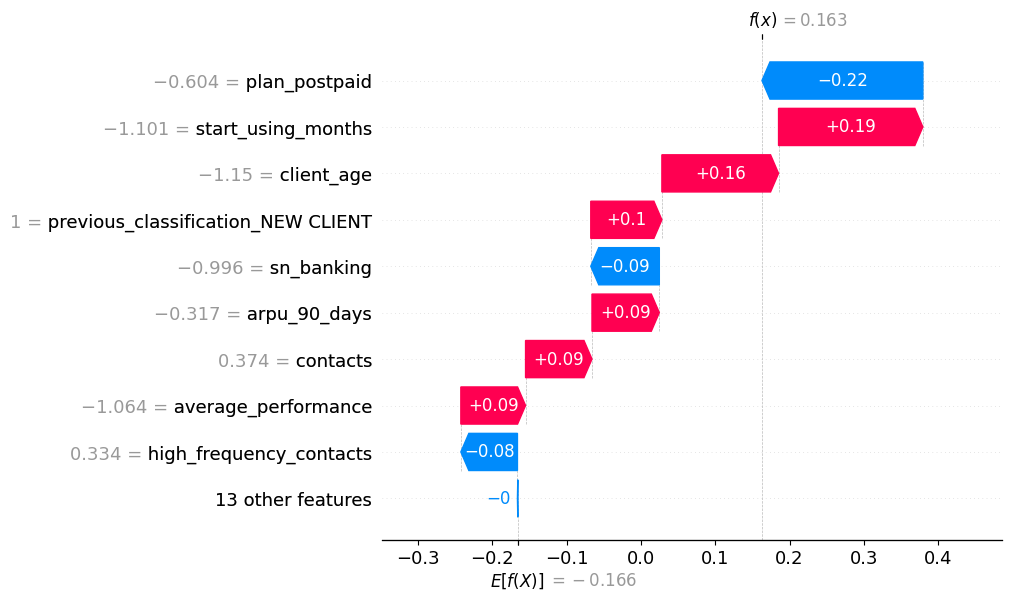

In [ ]:
shap.plots.waterfall(shap_values_sel_model[2])

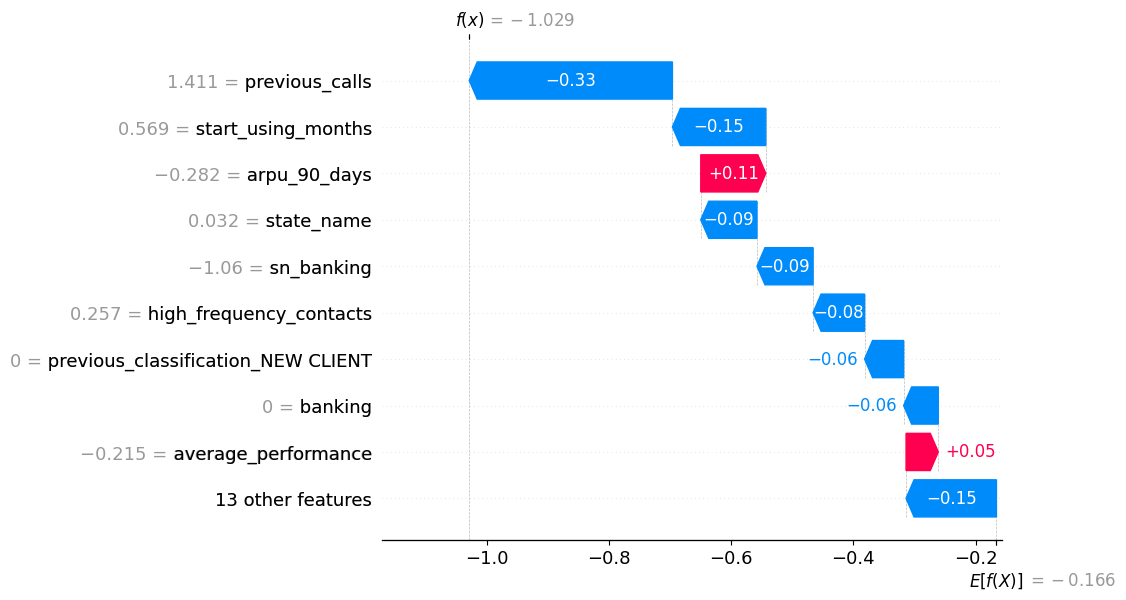

In [ ]:
shap.plots.waterfall(shap_values_sel_model[3])

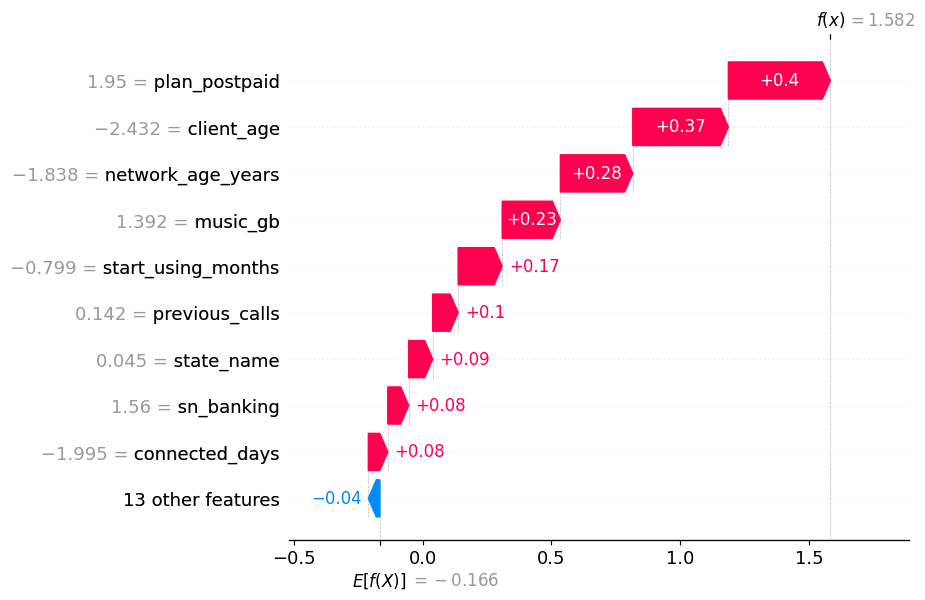

In [ ]:
shap.plots.waterfall(shap_values_sel_model[4])

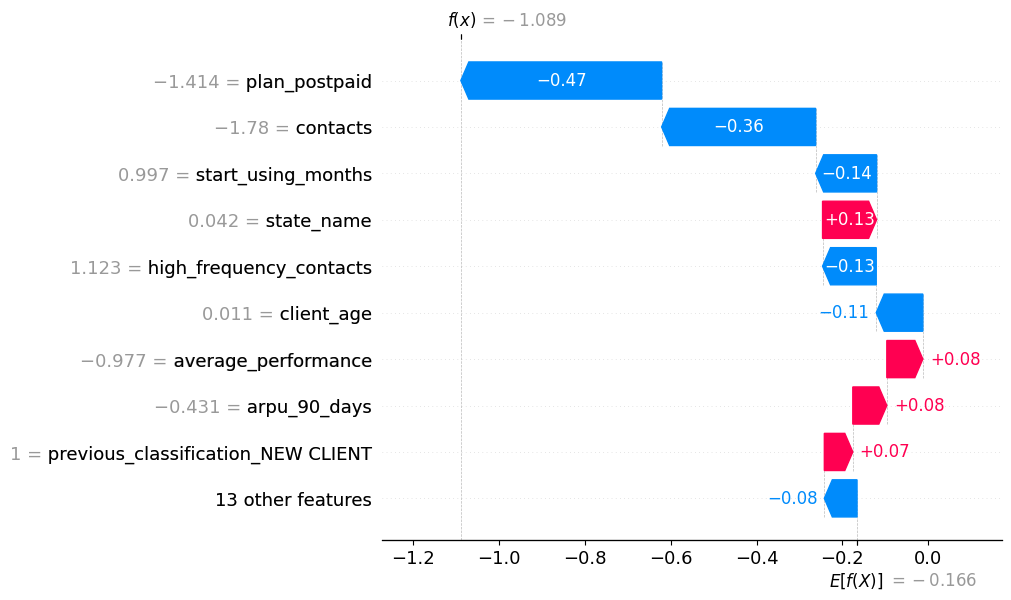

In [ ]:
shap.plots.waterfall(shap_values_sel_model[5])

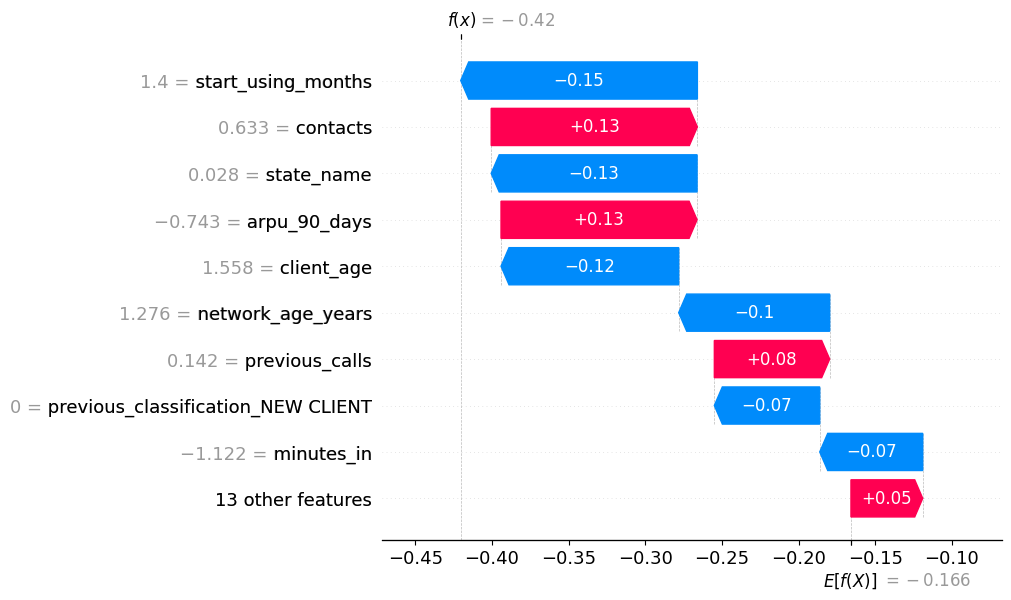

In [ ]:
shap.plots.waterfall(shap_values_sel_model[6])

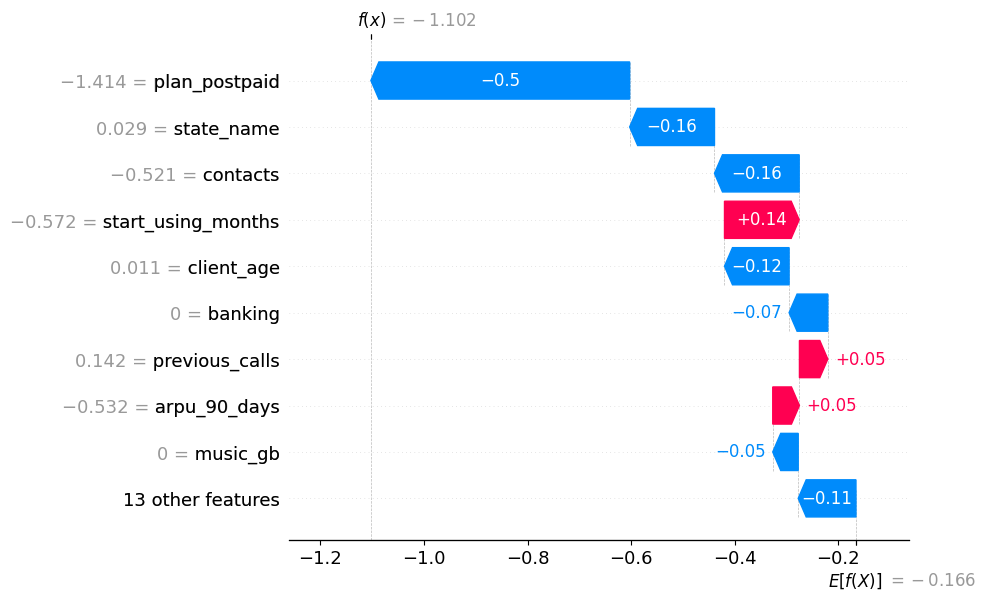

In [ ]:
shap.plots.waterfall(shap_values_sel_model[7])

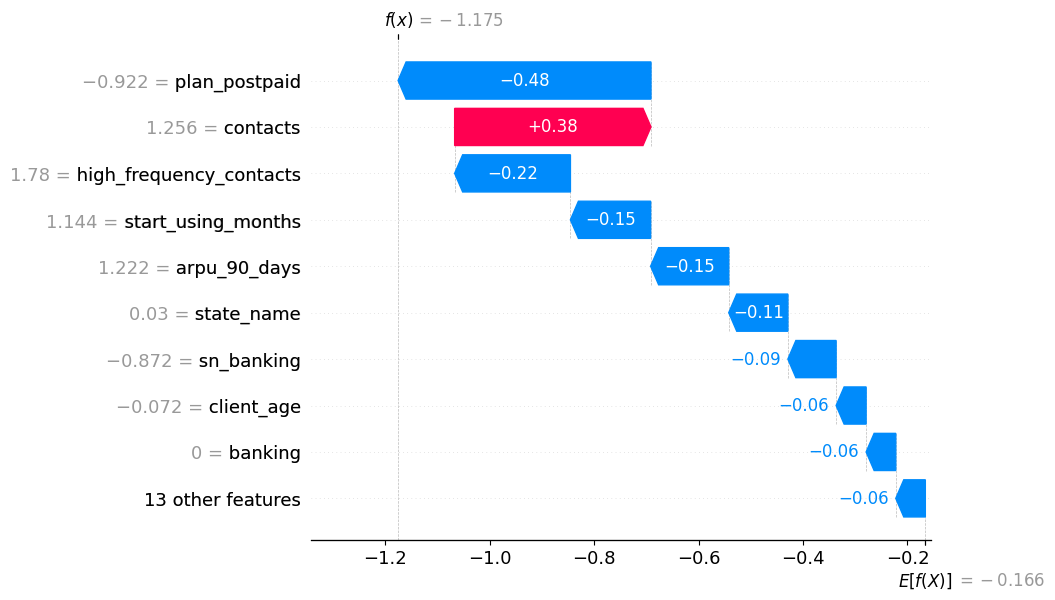

In [ ]:
shap.plots.waterfall(shap_values_sel_model[8])

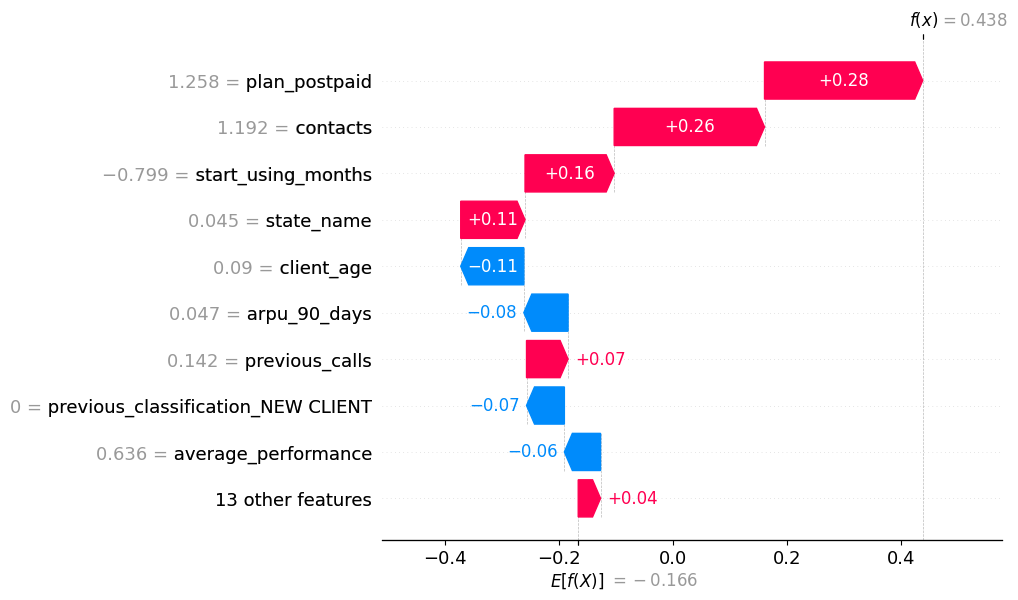

In [ ]:
shap.plots.waterfall(shap_values_sel_model[9])

## Preguntas Clave
**Valores faltantes y patrones**

En el dataset amplio prácticamente no hay nulos en variables clave como previous_classification; state_name tiene faltantes mínimos.

**Valores atípicos**

No se reportan outliers explícitos, pero por dispersión y colas largas en métricas de uso/consumo es esperable presencia de extremos estructurales.

**Cardinalidad de categóricas**

state_name (baja–media cardinalidad, ~22 deptos) y previous_classification (pocas clases).

**Distribuciones sesgadas / transformaciones**

Variables de montos/frecuencias exhiben sesgo positivo.

**Tendencia temporal**

El notebook no muestra análisis temporal explícito.

**Correlación dependiente–independientes**

No se listan coeficientes/correlogramas, pero el desempeño por umbral sugiere señal útil en features operativas (recencia, uso, bancarización, llamadas previas).

**Normalización de imágenes**

No aplica al cuadro.

**Desbalance de clases**

La prevalencia positiva es ≈ 3.7–3.8% (precisión a umbral 0.00 ≈ 0.037–0.038 en tablas de umbral).

## Conclusiones Generales

La base para el Cuadro Informativo Inteligente de Cliente es operable y consistente con los objetivos del Proyecto Integrador: presenta ausencias focalizadas en pocas variables críticas (p.ej., edad), que deben tratarse como señal (banderas “missing”) complementada con imputación condicional para no sesgar la interpretabilidad. Las variables numéricas de comportamiento muestran dispersión y sesgo positivo (colas largas), en segmentos de alto valor, los “outliers” conservan información útil para el discurso de venta y deben preservarse y etiquetarse en la UI. Las categóricas principales exhiben cardinalidad manejable, usar impact/target encoding con validación cruzada y consolidar categorías raras para estabilizar el modelo. 

La señal de negocio se concentra en variables operativas y de afinidad/oferta; su estabilidad en SHAP (global y local) debe auditarse por segmento, fijando un núcleo de drivers y alertas cuando el top-10 SHAP varíe de forma material. Con estos cimientos, un speech sugerido mapeado a esos drivers, reduciendo AHT y elevando conversión, bajo un marco de gobernanza de datos (data card de imputaciones/transformaciones, bitácora de modelos y trazabilidad QA).